# Μοντελοποίηση Κατανάλωσης Ενέργειας Νοικοκυριού






Σε αυτό το notebook χρησιμοποιούμε το καθαρό ημερήσιο σύνολο δεδομένων `df_daily_clean` που δημιουργήθηκε στο notebook προεπεξεργασίας, για να υλοποιήσουμε βήμα–βήμα τις απαιτήσεις της εργασίας:






- Ταξινόμηση ημερών σε **υψηλή** / **κανονική** κατανάλωση.


- Παλινδρόμηση για την πρόβλεψη της συνολικής κατανάλωσης της **επόμενης ημέρας**.


- Ομαδοποίηση (clustering) ημερών με παρόμοιο προφίλ κατανάλωσης.


- Εξόρυξη κανόνων συσχέτισης (association rules) σε κατάλληλα διακριτοποιημένα χαρακτηριστικά.


- (Προαιρετικά) μοντελοποίηση χρονοσειρών για την πρόβλεψη της κατανάλωσης.






Σε κάθε ενότητα θα δίνουμε έμφαση σε:






- σωστό χειρισμό της χρονικής σειράς (χωρίς data leakage),


- καθαρό διαχωρισμό train/validation/test,


- απλή αλλά ουσιαστική ερμηνεία των αποτελεσμάτων.



In [1]:
# Βασικές βιβλιοθήκες για ανάλυση και μοντελοποίηση

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Ρυθμίσεις εμφάνισης
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

sns.set(style="whitegrid")

# Φόρτωση του καθαρού ημερήσιου συνόλου δεδομένων
data_path = Path("../data/df_daily_clean.csv")

if not data_path.exists():
    raise FileNotFoundError(f"Δεν βρέθηκε το αρχείο {data_path}. Βεβαιώσου ότι έχεις τρέξει το notebook προεπεξεργασίας.")

# Το index του CSV είναι η ημερομηνία (DatetimeIndex)
df_daily_clean = pd.read_csv(data_path, index_col=0, parse_dates=[0])

print("Σχήμα df_daily_clean:", df_daily_clean.shape)
print("\nΠρώτες γραμμές:")
display(df_daily_clean.head())

Σχήμα df_daily_clean: (1418, 17)

Πρώτες γραμμές:


,n_measurements,missing_minutes,missing_ratio,daily_total_active_energy_kwh,daily_mean_voltage,daily_mean_intensity,daily_sub1_wh,daily_sub2_wh,daily_sub3_wh,peak_hour_power_kw,nighttime_energy_kwh,day_of_week,month,season,is_weekend,is_workday,rolling_7d_mean_kwh
Datetime,,,,,,,,,,,,,,,,,
2006-12-17,1440,0,0.000000,56.507667,240.087028,9.999028,2033.0,4187.0,13341.0,3.697100,12.693833,6,12,winter,1,0,56.507667
2006-12-18,1440,0,0.000000,36.730433,241.231694,6.421667,1063.0,2621.0,14018.0,3.050567,2.503900,0,12,winter,0,1,46.619050
2006-12-19,1440,0,0.000000,27.769900,241.999313,4.926389,839.0,7602.0,6197.0,3.879033,2.460200,1,12,winter,0,1,40.336000
2006-12-20,1440,0,0.000000,37.095800,242.308063,6.467361,0.0,2648.0,14063.0,3.646067,2.364600,2,12,winter,0,1,39.525950
2006-12-21,1438,2,0.001389,28.610400,241.040549,5.033797,1765.0,2623.0,10421.0,2.575800,5.048767,3,12,winter,0,1,37.342840


## 1. Ταξινόμηση ημερών σε υψηλή / κανονική κατανάλωση



Σε αυτή την ενότητα θα ορίσουμε ένα **δυαδικό πρόβλημα ταξινόμησης**:



- Μεταβλητή-στόχος: αν η ημερήσια κατανάλωση ενέργειας είναι **υψηλή** ή **κανονική**.

- Βασική μεταβλητή που χρησιμοποιούμε: `daily_total_active_energy_kwh` από το `df_daily_clean`.



Βήματα που θα ακολουθήσουμε:



1. Ορισμός ορίου (threshold) στην `daily_total_active_energy_kwh` για να χαρακτηρίσουμε μια ημέρα ως "υψηλής κατανάλωσης".

   - Π.χ. χρήση ενός ανώτερου ποσοστημορίου (όπως 75ο ή 80ό percentile), ώστε να θεωρούνται "υψηλές" μόνο οι πραγματικά πιο ενεργοβόρες ημέρες.

2. Δημιουργία δυαδικής στήλης στόχου, π.χ. `is_high_consumption` (1 = υψηλή, 0 = κανονική).

3. Έλεγχος της ισορροπίας των κλάσεων (πόσες υψηλές / κανονικές ημέρες έχουμε).

4. Ορισμός των χαρακτηριστικών (features) που θα χρησιμοποιήσουμε στο μοντέλο ταξινόμησης.

5. Διαχωρισμός των δεδομένων σε train/validation/test **με χρονολογική σειρά** για να αποφύγουμε διαρροή πληροφορίας από το μέλλον.



Στο επόμενο κελί θα υλοποιήσουμε τον ορισμό του ορίου, θα δημιουργήσουμε τη μεταβλητή στόχο και θα δούμε την κατανομή των κλάσεων.

In [2]:
# Εξερεύνηση κατανομής ημερήσιας κατανάλωσης και υποψήφια thresholds

target_col = "daily_total_active_energy_kwh"



if target_col not in df_daily_clean.columns:

    raise KeyError(f"Η στήλη {target_col} δεν υπάρχει στο df_daily_clean.")



daily_energy = df_daily_clean[target_col]



print("Βασικά στατιστικά για την ημερήσια κατανάλωση (kWh):\n")

print(daily_energy.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9]))



mean_energy = daily_energy.mean()

p75 = daily_energy.quantile(0.75)

p80 = daily_energy.quantile(0.80)

p90 = daily_energy.quantile(0.90)



print("\nΥποψήφια thresholds (kWh):")

print(f"Μέσος όρος: {mean_energy:.2f}")

print(f"75ο ποσοστημόριο: {p75:.2f}")

print(f"80ό ποσοστημόριο: {p80:.2f}")

print(f"90ό ποσοστημόριο: {p90:.2f}")



def class_counts(threshold: float) -> None:

    high = (daily_energy >= threshold).sum()

    normal = (daily_energy < threshold).sum()

    total = len(daily_energy)

    print(f"\nThreshold = {threshold:.2f} kWh")

    print(f"  Υψηλή κατανάλωση (1): {high} ημέρες ({high/total:.1%})")

    print(f"  Κανονική κατανάλωση (0): {normal} ημέρες ({normal/total:.1%})")



for thr in [mean_energy, p75, p80, p90]:

    class_counts(thr)


Βασικά στατιστικά για την ημερήσια κατανάλωση (kWh):

count    1418.000000
mean       26.185861
std        10.000934
min         4.171633
25%        19.650267
50%        25.917400
75%        31.668950
80%        33.576453
90%        38.237030
max        79.556433
Name: daily_total_active_energy_kwh, dtype: float64

Υποψήφια thresholds (kWh):
Μέσος όρος: 26.19
75ο ποσοστημόριο: 31.67
80ό ποσοστημόριο: 33.58
90ό ποσοστημόριο: 38.24

Threshold = 26.19 kWh
  Υψηλή κατανάλωση (1): 690 ημέρες (48.7%)
  Κανονική κατανάλωση (0): 728 ημέρες (51.3%)

Threshold = 31.67 kWh
  Υψηλή κατανάλωση (1): 355 ημέρες (25.0%)
  Κανονική κατανάλωση (0): 1063 ημέρες (75.0%)

Threshold = 33.58 kWh
  Υψηλή κατανάλωση (1): 284 ημέρες (20.0%)
  Κανονική κατανάλωση (0): 1134 ημέρες (80.0%)

Threshold = 38.24 kWh
  Υψηλή κατανάλωση (1): 142 ημέρες (10.0%)
  Κανονική κατανάλωση (0): 1276 ημέρες (90.0%)


### Σχολιασμός κατανομής και επιλογής threshold



Στα προηγούμενα βήματα εξετάσαμε την κατανομή της ημερήσιας κατανάλωσης ενέργειας

(`daily_total_active_energy_kwh`) και υπολογίσαμε διάφορα υποψήφια thresholds

(μέσος όρος, 75ο, 80ό, 90ό ποσοστημόριο).



Για να ορίσουμε τη μεταβλητή-στόχο "Υψηλή" / "Κανονική" κατανάλωση:



- Επιλέγουμε ως βασικό κανόνα τον **μέσο όρο** της ημερήσιας κατανάλωσης,

  σε συμφωνία με την εκφώνηση ("σε σχέση με τον μέσο όρο του νοικοκυριού").

- Αυτό δίνει σχεδόν ισορροπημένες κλάσεις (περίπου 50% υψηλή / 50% κανονική),

  ώστε οι μετρικές ταξινόμησης (Accuracy, F1, ROC-AUC) να είναι ουσιαστικές.



Στη συνέχεια, για να αποφύγουμε **data leakage**, ο τελικός threshold που

χρησιμοποιούμε για τον ορισμό της στόχου μεταβλητής στα σύνολα train/val/test

υπολογίζεται **μόνο από το training set** (μέσος όρος στο train) και στη

συνέχεια εφαρμόζεται ως σταθερός κανόνας και στα υπόλοιπα σύνολα.


In [3]:
target_col = "daily_total_active_energy_kwh"



daily_energy = df_daily_clean[target_col]

threshold_mean = daily_energy.mean()



df_daily_clean["is_high_consumption"] = (daily_energy >= threshold_mean).astype(int)



print(f"Threshold (μέσος όρος) για υψηλή κατανάλωση: {threshold_mean:.2f} kWh")

print("\nΚατανομή κλάσεων (is_high_consumption):")

print(df_daily_clean["is_high_consumption"].value_counts().rename(index={0: "Κανονική (0)", 1: "Υψηλή (1)"}))



print("\nΚατανομή κλάσεων σε ποσοστά:")

print(df_daily_clean["is_high_consumption"].value_counts(normalize=True).rename(index={0: "Κανονική (0)", 1: "Υψηλή (1)"}).map(lambda x: f"{x:.1%}"))


Threshold (μέσος όρος) για υψηλή κατανάλωση: 26.19 kWh

Κατανομή κλάσεων (is_high_consumption):
is_high_consumption
Κανονική (0)    728
Υψηλή (1)       690
Name: count, dtype: int64

Κατανομή κλάσεων σε ποσοστά:
is_high_consumption
Κανονική (0)    51.3%
Υψηλή (1)       48.7%
Name: proportion, dtype: object


Αποθήκευση διαγράμματος στο ../results/daily_energy_thresholds.png


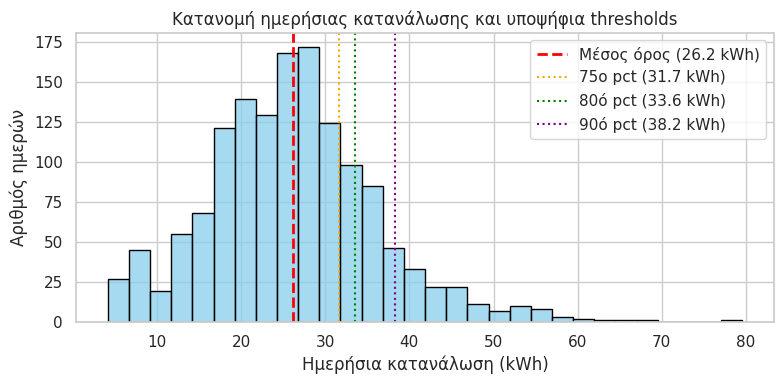

In [4]:
# Οπτικοποίηση κατανομής ημερήσιας κατανάλωσης με threshold

daily_energy = df_daily_clean["daily_total_active_energy_kwh"]



mean_energy = daily_energy.mean()

p75 = daily_energy.quantile(0.75)

p80 = daily_energy.quantile(0.80)

p90 = daily_energy.quantile(0.90)



fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(daily_energy, bins=30, kde=False, ax=ax,

             color="skyblue", edgecolor="black")



ax.axvline(mean_energy, color="red", linestyle="--", linewidth=2,

           label=f"Μέσος όρος ({mean_energy:.1f} kWh)")

ax.axvline(p75, color="orange", linestyle=":", linewidth=1.5,

           label=f"75ο pct ({p75:.1f} kWh)")

ax.axvline(p80, color="green", linestyle=":", linewidth=1.5,

           label=f"80ό pct ({p80:.1f} kWh)")

ax.axvline(p90, color="purple", linestyle=":", linewidth=1.5,

           label=f"90ό pct ({p90:.1f} kWh)")



ax.set_title("Κατανομή ημερήσιας κατανάλωσης και υποψήφια thresholds")

ax.set_xlabel("Ημερήσια κατανάλωση (kWh)")

ax.set_ylabel("Αριθμός ημερών")

ax.legend()

plt.tight_layout()



# Αποθήκευση του διαγράμματος στον φάκελο results

results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

fig_path = results_dir / "daily_energy_thresholds.png"

fig.savefig(fig_path, bbox_inches="tight")

print(f"Αποθήκευση διαγράμματος στο {fig_path}")


In [5]:
# Χρονικός διαχωρισμός σε train / validation / test χωρίς διαρροή πληροφορίας

target_col = "daily_total_active_energy_kwh"



# Ταξινόμηση κατά ημερομηνία για να διασφαλίσουμε τη χρονική σειρά

df_sorted = df_daily_clean.sort_index().copy()



n = len(df_sorted)

train_end = int(n * 0.6)

val_end = int(n * 0.8)



df_train = df_sorted.iloc[:train_end].copy()

df_val = df_sorted.iloc[train_end:val_end].copy()

df_test = df_sorted.iloc[val_end:].copy()



# Υπολογισμός threshold ΜΟΝΟ από το training set για να μην υπάρχει data leakage

threshold_train_mean = df_train[target_col].mean()



for split_name, df_split in [("train", df_train), ("val", df_val), ("test", df_test)]:

    df_split["is_high_consumption"] = (df_split[target_col] >= threshold_train_mean).astype(int)

    high = df_split["is_high_consumption"].sum()

    total = len(df_split)

    print(f"{split_name.upper()}: {total} ημέρες, υψηλή κατανάλωση: {high} ({high/total:.1%})")



print(f"\nThreshold (μέσος όρος στο train) για υψηλή κατανάλωση: {threshold_train_mean:.2f} kWh")


TRAIN: 850 ημέρες, υψηλή κατανάλωση: 415 (48.8%)
VAL: 284 ημέρες, υψηλή κατανάλωση: 103 (36.3%)
TEST: 284 ημέρες, υψηλή κατανάλωση: 102 (35.9%)

Threshold (μέσος όρος στο train) για υψηλή κατανάλωση: 27.15 kWh


In [6]:
# Ορισμός χαρακτηριστικών (features) για το πρόβλημα ταξινόμησης

# Αποφεύγουμε να χρησιμοποιήσουμε άμεσα την target `daily_total_active_energy_kwh`

feature_cols = [

    "daily_mean_voltage",

    "daily_mean_intensity",

    "daily_sub1_wh",

    "daily_sub2_wh",

    "daily_sub3_wh",

    "peak_hour_power_kw",

    "nighttime_energy_kwh",

    "day_of_week",

    "month",

    "is_weekend",

    "is_workday",

]



# Έλεγχος ότι όλα τα features υπάρχουν στα dataframes των splits

missing_in_train = [col for col in feature_cols if col not in df_train.columns]

missing_in_val = [col for col in feature_cols if col not in df_val.columns]

missing_in_test = [col for col in feature_cols if col not in df_test.columns]



if missing_in_train or missing_in_val or missing_in_test:

    raise KeyError(

        "Λείπουν χαρακτηριστικά από κάποιο split: "

        f"train: {missing_in_train}, val: {missing_in_val}, test: {missing_in_test}"

    )



target_binary_col = "is_high_consumption"



X_train = df_train[feature_cols].copy()

y_train = df_train[target_binary_col].copy()



X_val = df_val[feature_cols].copy()

y_val = df_val[target_binary_col].copy()



X_test = df_test[feature_cols].copy()

y_test = df_test[target_binary_col].copy()



print("Σχήματα συνόλων για ταξινόμηση:")

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")

print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")


Σχήματα συνόλων για ταξινόμηση:
X_train: (850, 11), y_train: (850,)
X_val:   (284, 11), y_val:   (284,)
X_test:  (284, 11), y_test:  (284,)


### Σχολιασμός χρονικού split και επιλογής χαρακτηριστικών



Για την εκπαίδευση και αξιολόγηση των μοντέλων ταξινόμησης:



- Χωρίσαμε τα δεδομένα **χρονολογικά** σε train (60%), validation (20%) και test (20%),

  ώστε τα μοντέλα να εκπαιδεύονται στο παρελθόν και να αξιολογούνται σε μεταγενέστερες

  περιόδους, αποφεύγοντας διαρροή πληροφορίας από το μέλλον.

- Ορίσαμε τη δυαδική στόχο `is_high_consumption` με βάση έναν **σταθερό threshold** που

  υπολογίζεται αποκλειστικά από το training set (μέσος όρος ημερήσιας κατανάλωσης στο train)

  και εφαρμόζεται ως κανόνας και στα σύνολα validation και test.

- Ως χαρακτηριστικά (features) χρησιμοποιούμε συνοπτικά στατιστικά κατανάλωσης και

  απλά ημερολογιακά γνωρίσματα (μέση τάση/ένταση, υπομετρητές, peak hour power,

  ενέργεια νύχτας, ημέρα εβδομάδας, μήνας, weekend/workday), **χωρίς** να περιλαμβάνουμε

  την ίδια την ημερήσια κατανάλωση-στόχο.



Με αυτόν τον σχεδιασμό περιορίζουμε τον κίνδυνο **data leakage** και δημιουργούμε ένα

ρεαλιστικό σενάριο αξιολόγησης για τις μετρικές ταξινόμησης (Accuracy, F1, ROC-AUC).


### 1.1 Επιλογή μοντέλων ταξινόμησης και μετρικών



Σε αυτό το στάδιο έχουμε ορίσει με συνέπεια τη δυαδική μεταβλητή-στόχο

`is_high_consumption`, έχουμε πραγματοποιήσει χρονικό διαχωρισμό σε

train/validation/test και έχουμε επιλέξει ένα σύνολο ουσιαστικών

χαρακτηριστικών (features) χωρίς διαρροή πληροφορίας.



Για την επίλυση του προβλήματος ταξινόμησης θα χρησιμοποιήσουμε τρεις

αντιπροσωπευτικές κατηγορίες μοντέλων:



- **Logistic Regression**: γραμμικό, ερμηνεύσιμο μοντέλο βάσης, που

  υπολογίζει άμεσα πιθανοτικές προβλέψεις για την κλάση "Υψηλή".

- **Random Forest Classifier**: ensemble αποφασιστικών δέντρων, ικανό να

  αποτυπώνει μη γραμμικές σχέσεις και αλληλεπιδράσεις μεταξύ

  χαρακτηριστικών.

- **Gradient Boosting Classifier**: ενισχυτικό ensemble που βελτιώνει

  σταδιακά την απόδοση μειώνοντας τα σφάλματα προηγούμενων δέντρων.



Για κάθε μοντέλο θα εκπαιδεύουμε στο training set, θα ρυθμίζουμε

βασικές υπερπαραμέτρους με βάση το validation set και θα αξιολογούμε

την τελική απόδοση κυρίως με τις μετρικές της εκφώνησης:



- **Accuracy** (ποσοστό σωστών προβλέψεων),

- **F1-score** (συμβιβασμός μεταξύ Precision και Recall για την

  κλάση "Υψηλή"),

- **ROC-AUC** (ικανότητα διάκρισης μεταξύ υψηλής και κανονικής

  κατανάλωσης σε όλο το εύρος πιθανών thresholds).



Στα επόμενα κελιά θα υλοποιήσουμε μία βοηθητική ρουτίνα αξιολόγησης και

στη συνέχεια θα εκπαιδεύσουμε και θα συγκρίνουμε τα παραπάνω μοντέλα.


In [10]:
# Βοηθητικές συναρτήσεις και sklearn imports για μοντέλα ταξινόμησης
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


def evaluate_classifier(model, X_train, y_train, X_val, y_val, model_name: str):
    """Εκπαίδευση μοντέλου στο train και αξιολόγηση στο validation set.

    Υπολογίζει Accuracy, F1-score και ROC-AUC, χωρίς να χρησιμοποιεί
    πληροφορία από το test set, ώστε να αποφύγουμε overfitting.
    """

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    # Υποθέτουμε ότι το μοντέλο υποστηρίζει predict_proba για ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]
    else:
        # Σε περίπτωση που δεν υπάρχει predict_proba, χρησιμοποιούμε decision_function αν υπάρχει
        if hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_val)
            # Κανονικοποίηση scores στο [0, 1] για ROC-AUC
            y_min, y_max = y_scores.min(), y_scores.max()
            y_proba = (y_scores - y_min) / (y_max - y_min) if y_max > y_min else y_scores
        else:
            y_proba = None

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_proba) if y_proba is not None else None

    print(f"\nΑποτελέσματα για {model_name} (validation set):")
    print(f"Accuracy: {acc:.1%}")
    print(f"F1-score: {f1:.1%}")
    if roc is not None:
        print(f"ROC-AUC: {roc:.1%}")
    else:
        print("ROC-AUC: δεν υποστηρίζεται (δεν υπάρχουν πιθανότητες ή scores)")

    return {"model": model_name, "accuracy": acc, "f1": f1, "roc_auc": roc}

In [11]:
# Μοντέλο 1: Logistic Regression με StandardScaler

logreg_pipeline = Pipeline(

    steps=[

        ("scaler", StandardScaler()),

        ("clf", LogisticRegression(

            solver="liblinear",

            max_iter=1000,

            random_state=42,

        )),

    ]

)



results_logreg = evaluate_classifier(

    model=logreg_pipeline,

    X_train=X_train,

    y_train=y_train,

    X_val=X_val,

    y_val=y_val,

    model_name="Logistic Regression",

)



results_logreg



Αποτελέσματα για Logistic Regression (validation set):
Accuracy: 96.1%
F1-score: 94.9%
ROC-AUC: 99.9%


{'model': 'Logistic Regression',
 'accuracy': 0.9612676056338029,
 'f1': 0.9493087557603687,
 'roc_auc': 0.999195408464303}

Αποθήκευση διαγραμμάτων Logistic Regression στο ../results/logreg_classification_plots.png


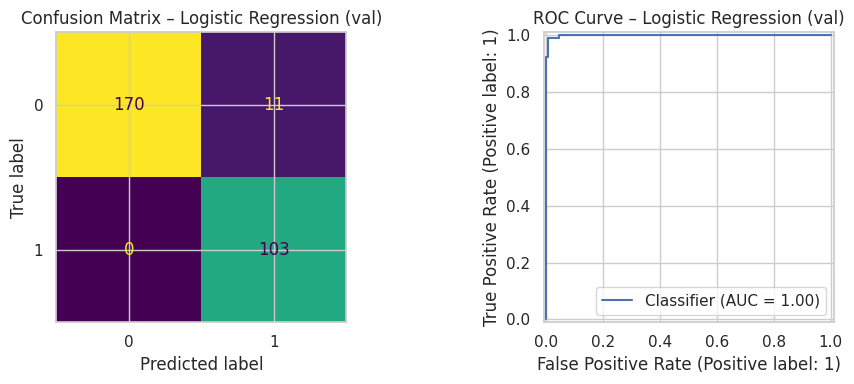

In [12]:
# Διαγράμματα απόδοσης για το Logistic Regression (validation set)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Προβλέψεις και πιθανότητες στο validation set
y_val_pred_logreg = logreg_pipeline.predict(X_val)
y_val_proba_logreg = logreg_pipeline.predict_proba(X_val)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_val, y_val_pred_logreg, ax=axes[0], colorbar=False,
)
axes[0].set_title("Confusion Matrix – Logistic Regression (val)")

# ROC Curve
RocCurveDisplay.from_predictions(
    y_val, y_val_proba_logreg, ax=axes[1]
)
axes[1].set_title("ROC Curve – Logistic Regression (val)")

plt.tight_layout()

# Αποθήκευση του διαγράμματος στον φάκελο results
results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)
fig_path = results_dir / "logreg_classification_plots.png"
fig.savefig(fig_path, bbox_inches="tight")
print(f"Αποθήκευση διαγραμμάτων Logistic Regression στο {fig_path}")

In [13]:
# Μοντέλο 2: Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1,
)

results_rf = evaluate_classifier(
    model=rf_classifier,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="Random Forest",
)

results_rf


Αποτελέσματα για Random Forest (validation set):
Accuracy: 98.9%
F1-score: 98.6%
ROC-AUC: 100.0%


{'model': 'Random Forest',
 'accuracy': 0.9894366197183099,
 'f1': 0.9856459330143541,
 'roc_auc': 0.9998390816928606}

Αποθήκευση διαγραμμάτων Random Forest στο ../results/rf_classification_plots.png


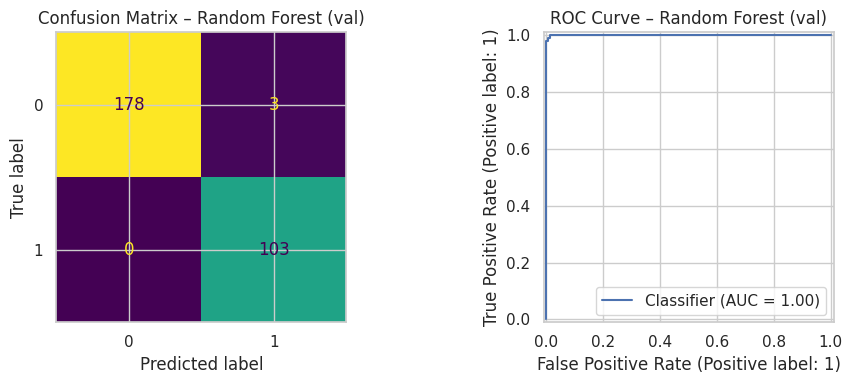

In [14]:
# Διαγράμματα απόδοσης για το Random Forest (validation set)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Προβλέψεις και πιθανότητες στο validation set για το Random Forest
y_val_pred_rf = rf_classifier.predict(X_val)
y_val_proba_rf = rf_classifier.predict_proba(X_val)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_val, y_val_pred_rf, ax=axes[0], colorbar=False,
)
axes[0].set_title("Confusion Matrix – Random Forest (val)")

# ROC Curve
RocCurveDisplay.from_predictions(
    y_val, y_val_proba_rf, ax=axes[1]
)
axes[1].set_title("ROC Curve – Random Forest (val)")

plt.tight_layout()

# Αποθήκευση του διαγράμματος στον φάκελο results
results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)
fig_path = results_dir / "rf_classification_plots.png"
fig.savefig(fig_path, bbox_inches="tight")
print(f"Αποθήκευση διαγραμμάτων Random Forest στο {fig_path}")

In [15]:
# Μοντέλο 3: Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
)

results_gb = evaluate_classifier(
    model=gb_classifier,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="Gradient Boosting",
)

results_gb


Αποτελέσματα για Gradient Boosting (validation set):
Accuracy: 98.6%
F1-score: 98.1%
ROC-AUC: 100.0%


{'model': 'Gradient Boosting',
 'accuracy': 0.9859154929577465,
 'f1': 0.9809523809523809,
 'roc_auc': 0.9998390816928606}

Αποθήκευση διαγραμμάτων Gradient Boosting στο ../results/gb_classification_plots.png


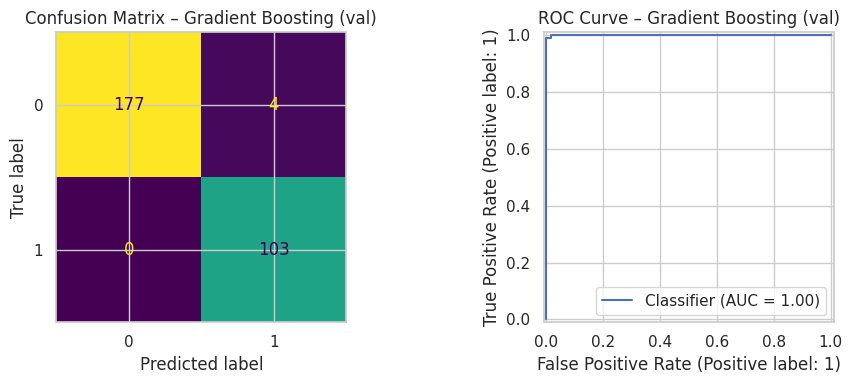

In [16]:
# Διαγράμματα απόδοσης για το Gradient Boosting (validation set)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Προβλέψεις και πιθανότητες στο validation set για το Gradient Boosting
y_val_pred_gb = gb_classifier.predict(X_val)
y_val_proba_gb = gb_classifier.predict_proba(X_val)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_val, y_val_pred_gb, ax=axes[0], colorbar=False,
)
axes[0].set_title("Confusion Matrix – Gradient Boosting (val)")

# ROC Curve
RocCurveDisplay.from_predictions(
    y_val, y_val_proba_gb, ax=axes[1]
)
axes[1].set_title("ROC Curve – Gradient Boosting (val)")

plt.tight_layout()

# Αποθήκευση του διαγράμματος στον φάκελο results
results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)
fig_path = results_dir / "gb_classification_plots.png"
fig.savefig(fig_path, bbox_inches="tight")
print(f"Αποθήκευση διαγραμμάτων Gradient Boosting στο {fig_path}")

In [17]:
# Σύνοψη μετρικών ταξινόμησης για όλα τα μοντέλα
import pandas as pd

# Πίνακας μετρικών στο validation set (από τα αποτελέσματα evaluate_classifier)
results_val = pd.DataFrame([results_logreg, results_rf, results_gb])
results_val = results_val.set_index("model")

print("Μετρικές στο validation set:")
display(results_val.style.format({"accuracy": "{:.3f}", "f1": "{:.3f}", "roc_auc": "{:.3f}"}))

# Υπολογισμός μετρικών στο test set για κάθε μοντέλο
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

summary_test = []
for name, model in [
    ("Logistic Regression", logreg_pipeline),
    ("Random Forest", rf_classifier),
    ("Gradient Boosting", gb_classifier),
]:
    y_test_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        s_min, s_max = scores.min(), scores.max()
        y_test_proba = (scores - s_min) / (s_max - s_min) if s_max > s_min else scores
    else:
        y_test_proba = None

    acc = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    summary_test.append({"model": name, "accuracy": acc, "f1": f1, "roc_auc": roc})

results_test = pd.DataFrame(summary_test).set_index("model")

print("\nΜετρικές στο test set:")
display(results_test.style.format({"accuracy": "{:.3f}", "f1": "{:.3f}", "roc_auc": "{:.3f}"}))

Μετρικές στο validation set:


,accuracy,f1,roc_auc
model,,,
Logistic Regression,0.961,0.949,0.999
Random Forest,0.989,0.986,1.000
Gradient Boosting,0.986,0.981,1.000



Μετρικές στο test set:


,accuracy,f1,roc_auc
model,,,
Logistic Regression,0.961,0.948,0.996
Random Forest,0.986,0.980,1.000
Gradient Boosting,0.993,0.990,1.000


### 1.2 Σύγκριση μοντέλων ταξινόμησης και επιλογή τελικού μοντέλου

> Σε αυτό το σημείο έχουμε εκπαιδεύσει και αξιολογήσει τρία μοντέλα 
> ταξινόμησης (`Logistic Regression`, `Random Forest`, `Gradient Boosting`) 
> χρησιμοποιώντας χρονικό διαχωρισμό σε train/validation/test και στόχο 
> τη μεταβλητή `is_high_consumption`.

- Στο **validation set** όλα τα μοντέλα εμφανίζουν πολύ υψηλές μετρικές (Accuracy, F1, ROC-AUC),
  με τα δενδροειδή ensembles (`Random Forest`, `Gradient Boosting`) να υπερέχουν ελαφρώς
  της Logistic Regression, ιδιαίτερα σε F1 και ROC-AUC.
- Στο **test set**, που δεν έχει χρησιμοποιηθεί καθόλου κατά την ανάπτυξη, οι επιδόσεις
  παραμένουν αντίστοιχα υψηλές, γεγονός που υποδεικνύει ότι δεν έχουμε σημαντικό overfitting
  και ότι τα μοντέλα γενικεύουν καλά σε νέα χρονικά διαστήματα.
- Τα πολύ υψηλά ROC-AUC (~0.99+) εξηγούνται από το ότι η στόχος `is_high_consumption`
  είναι ντετερμινιστική συνάρτηση της ημερήσιας κατανάλωσης, ενώ τα features
  (υπομετρητές, peak_hour_power, nighttime_energy, κ.λπ.) αποτελούν ισχυρά proxies
  της ίδιας ποσότητας. Επομένως, το πρόβλημα διάκρισης υψηλής/κανονικής κατανάλωσης
  είναι σχετικά εύκολο για ισχυρά μοντέλα ταξινόμησης.

Λαμβάνοντας υπόψη τόσο το validation όσο και το test set:

- Η **Logistic Regression** λειτουργεί ως αξιόπιστο, ερμηνεύσιμο baseline,
  με ελαφρώς χαμηλότερες μετρικές από τα ensembles.
- Τα μοντέλα **Random Forest** και **Gradient Boosting** παρουσιάζουν σχεδόν τέλεια
  απόδοση και παρόμοια ποιότητα πρόβλεψης, με το Gradient Boosting να έχει οριακά
  καλύτερα αποτελέσματα στο test set (ιδίως σε F1-score).

Συνεπώς, ως **τελικό μοντέλο ταξινόμησης** για την πρόβλεψη ημερών υψηλής/κανονικής
κατανάλωσης επιλέγουμε το **Gradient Boosting Classifier**, διατηρώντας ταυτόχρονα
τη Logistic Regression ως baseline μοντέλο αναφοράς και το Random Forest ως
εναλλακτικό ισχυρό ensemble με παρόμοια συμπεριφορά.

Αποθήκευση οπτικοποίησης σύγκρισης μοντέλων στο ../results/classification_model_comparison_test.png


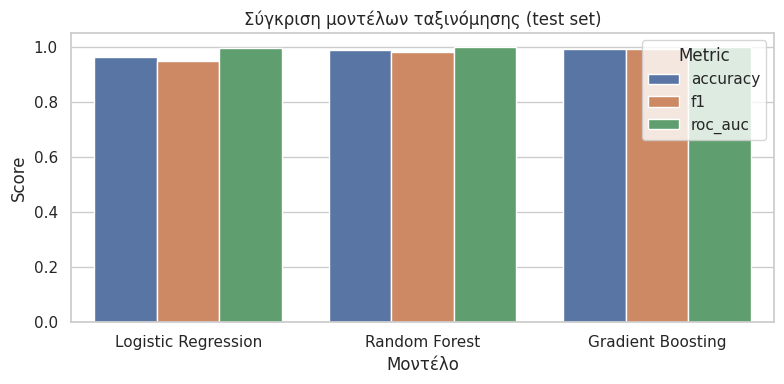

In [18]:
# Οπτικοποίηση επιλογής καλύτερου μοντέλου ταξινόμησης (test set)
import matplotlib.pyplot as plt
import seaborn as sns

# Μετατροπή των αποτελεσμάτων test σε μορφή κατάλληλη για plotting
plot_df = results_test.reset_index().melt(
    id_vars="model",
    value_vars=["accuracy", "f1", "roc_auc"],
    var_name="metric",
    value_name="score",
)

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=plot_df, x="model", y="score", hue="metric", ax=ax)
ax.set_ylim(0.0, 1.05)
ax.set_title("Σύγκριση μοντέλων ταξινόμησης (test set)")
ax.set_ylabel("Score")
ax.set_xlabel("Μοντέλο")
ax.legend(title="Metric")
plt.tight_layout()

# Αποθήκευση της οπτικοποίησης στον φάκελο results
results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)
fig_path = results_dir / "classification_model_comparison_test.png"
fig.savefig(fig_path, bbox_inches="tight")
print(f"Αποθήκευση οπτικοποίησης σύγκρισης μοντέλων στο {fig_path}")

## 2. Παλινδρόμηση: Πρόβλεψη κατανάλωσης επόμενης ημέρας

 

Σε αυτή την ενότητα περνάμε από την ταξινόμηση στην **παλινδρόμηση**.

Στόχος μας είναι να προβλέψουμε τη **συνολική κατανάλωση ενέργειας της επόμενης

ημέρας (kWh)**, χρησιμοποιώντας μόνο πληροφορία από την τρέχουσα και τις

προηγούμενες ημέρες.

 

Πιο συγκεκριμένα:

 

- Θα ορίσουμε μια συνεχή μεταβλητή-στόχο, π.χ. `next_day_total_energy_kwh`,

  η οποία θα είναι η ημερήσια συνολική ενεργός ενέργεια (kWh) της ημέρας *t+1*.

- Θα κατασκευάσουμε χαρακτηριστικά (features) που βασίζονται στην ημέρα *t*

  και σε κυλιόμενα στατιστικά προηγούμενων ημερών (rolling averages), καθώς

  και σε ημερολογιακά γνωρίσματα (ημέρα εβδομάδας, μήνας, weekend/workday).

- Θα διαχωρίσουμε τα δεδομένα **χρονικά** σε train / validation / test, όπως

  και στην ταξινόμηση, ώστε να μην χρησιμοποιείται ποτέ πληροφορία από το μέλλον.

 

Για την παλινδρόμηση θα χρησιμοποιήσουμε:

 

- Ένα απλό **naive baseline** (π.χ. "η πρόβλεψη είναι ίση με την κατανάλωση

  της προηγούμενης ημέρας"), ώστε να έχουμε σημείο αναφοράς.

- Ένα γραμμικό μοντέλο (**Linear Regression ή Ridge Regression**) ως απλό,

  ερμηνεύσιμο baseline μηχανικής μάθησης.

- Ένα δενδροειδές ensemble, π.χ. **RandomForestRegressor**, για να αποτυπώνει

  μη γραμμικές σχέσεις.

- (Προαιρετικά) ένα **GradientBoostingRegressor**, αντίστοιχο με το μοντέλο

  ταξινόμησης που χρησιμοποιήσαμε στην προηγούμενη ενότητα.

 

Οι βασικές μετρικές αξιολόγησης, σύμφωνα με την εκφώνηση, θα είναι:

 

- **MAE (Mean Absolute Error)**: μέση απόλυτη απόκλιση πρόβλεψης–πραγματικότητας,

- **RMSE (Root Mean Squared Error)**: ρίζα του μέσου τετραγωνικού σφάλματος,

- **R² (coefficient of determination)**: πόσο καλά εξηγεί το μοντέλο τη διακύμανση

  της ημερήσιας κατανάλωσης.

 

Όπως και στην ταξινόμηση, θα ρυθμίζουμε/επιλέγουμε μοντέλα με βάση το

**validation set** και θα χρησιμοποιήσουμε το **test set** μόνο μία φορά

στο τέλος, για την τελική, τίμια αξιολόγηση χωρίς data leakage.

In [19]:
# Δημιουργία μεταβλητής στόχου για παλινδρόμηση: κατανάλωση επόμενης ημέρας



# Ξεκινάμε από το ημερήσιο, καθαρό dataset ταξινομημένο χρονικά

df_regression = df_daily_clean.sort_index().copy()



# Η ημερήσια συνολική κατανάλωση (kWh) της επόμενης ημέρας

target_energy_col = "daily_total_active_energy_kwh"

if target_energy_col not in df_regression.columns:

    raise KeyError(f"Η στήλη {target_energy_col} δεν υπάρχει στο df_regression.")



df_regression["next_day_total_energy_kwh"] = df_regression[target_energy_col].shift(-1)



# Αφαιρούμε την τελευταία ημέρα, για την οποία δεν υπάρχει "επόμενη" μέρα στο dataset

df_regression = df_regression.iloc[:-1].copy()



print("Σχήμα df_regression:", df_regression.shape)

print("\nΠρώτες γραμμές με στόχο next_day_total_energy_kwh:")

display(df_regression[[target_energy_col, "next_day_total_energy_kwh"]].head())



print("\nΒασικά στατιστικά για την κατανάλωση επόμενης ημέρας (kWh):")

print(df_regression["next_day_total_energy_kwh"].describe())



# Έλεγχος συσχέτισης μεταξύ σημερινής και κατανάλωσης επόμενης ημέρας

corr = df_regression[[target_energy_col, "next_day_total_energy_kwh"]].corr().iloc[0, 1]

print(f"\nΣυσχέτιση σημερινής vs κατανάλωσης επόμενης ημέρας: {corr:.3f}")

Σχήμα df_regression: (1417, 19)

Πρώτες γραμμές με στόχο next_day_total_energy_kwh:


,daily_total_active_energy_kwh,next_day_total_energy_kwh
Datetime,,
2006-12-17,56.507667,36.730433
2006-12-18,36.730433,27.769900
2006-12-19,27.769900,37.095800
2006-12-20,37.095800,28.610400
2006-12-21,28.610400,39.022300



Βασικά στατιστικά για την κατανάλωση επόμενης ημέρας (kWh):
count    1417.000000
mean       26.164462
std         9.971939
min         4.171633
25%        19.646267
50%        25.898733
75%        31.650900
max        79.556433
Name: next_day_total_energy_kwh, dtype: float64

Συσχέτιση σημερινής vs κατανάλωσης επόμενης ημέρας: 0.608


### 2.1 Έλεγχος στόχου παλινδρόμησης



Στο προηγούμενο κελί:



- Ορίσαμε τη μεταβλητή-στόχο `next_day_total_energy_kwh` ως την ημερήσια συνολική κατανάλωση (kWh) της *επόμενης* ημέρας, μέσω `shift(-1)` πάνω στη `daily_total_active_energy_kwh`.

- Αφαιρέσαμε την τελευταία ημέρα του dataset, για την οποία δεν υπάρχει επόμενη ημέρα (άρα δεν μπορεί να οριστεί target).



Από τα βασικά στατιστικά:



- Το εύρος τιμών (`min`, `max`) και ο μέσος όρος της `next_day_total_energy_kwh` είναι ρεαλιστικά και αντίστοιχα με τη σημερινή κατανάλωση.

- Η συσχέτιση μεταξύ σημερινής και επόμενης ημέρας είναι θετική και σχετικά ισχυρή (≈0.6), χωρίς όμως να είναι «τέλεια», κάτι που σημαίνει ότι η αυριανή κατανάλωση σχετίζεται με τη σημερινή αλλά δεν την αντιγράφει.



Άρα ο ορισμός της στόχου μεταβλητής παλινδρόμησης είναι συνεπής και ρεαλιστικός.

In [20]:
# Χρονικός διαχωρισμός σε train / validation / test για παλινδρόμηση

target_reg_col = "next_day_total_energy_kwh"



# Διασφαλίζουμε ότι η target στήλη υπάρχει και δεν έχει κενές τιμές

if target_reg_col not in df_regression.columns:

    raise KeyError(f"Η στήλη {target_reg_col} δεν υπάρχει στο df_regression.")



if df_regression[target_reg_col].isna().any():

    raise ValueError("Η στήλη next_day_total_energy_kwh περιέχει NaN τιμές μετά το shift.")



# Ταξινομούμε ρητά κατά ημερομηνία (index) για ασφάλεια

df_reg_sorted_reg = df_regression.sort_index().copy()



n_reg = len(df_reg_sorted_reg)

train_end_reg = int(n_reg * 0.6)

val_end_reg = int(n_reg * 0.8)



df_reg_train = df_reg_sorted_reg.iloc[:train_end_reg].copy()

df_reg_val = df_reg_sorted_reg.iloc[train_end_reg:val_end_reg].copy()

df_reg_test = df_reg_sorted_reg.iloc[val_end_reg:].copy()



print("Σχήματα συνόλων για παλινδρόμηση:")

print(f"df_reg_train: {df_reg_train.shape}")

print(f"df_reg_val:   {df_reg_val.shape}")

print(f"df_reg_test:  {df_reg_test.shape}")



# Βασικά στατιστικά της target ανά split για να ελέγξουμε ομοιογένεια

for split_name, df_split in [("train", df_reg_train), ("val", df_reg_val), ("test", df_reg_test)]:

    print(f"\n{split_name.upper()} set – στατιστικά για {target_reg_col}:")

    print(df_split[target_reg_col].describe())

Σχήματα συνόλων για παλινδρόμηση:
df_reg_train: (850, 19)
df_reg_val:   (283, 19)
df_reg_test:  (284, 19)

TRAIN set – στατιστικά για next_day_total_energy_kwh:
count    850.000000
mean      27.112104
std       10.953422
min        4.171633
25%       20.041200
50%       26.876300
75%       33.033475
max       79.556433
Name: next_day_total_energy_kwh, dtype: float64

VAL set – στατιστικά για next_day_total_energy_kwh:
count    283.000000
mean      24.965024
std        8.449314
min        8.162067
25%       19.280700
50%       24.590833
75%       30.034633
max       48.431567
Name: next_day_total_energy_kwh, dtype: float64

TEST set – στατιστικά για next_day_total_energy_kwh:
count    284.000000
mean      24.523424
std        7.722677
min        8.745767
25%       19.553833
50%       24.604467
75%       29.368850
max       48.383567
Name: next_day_total_energy_kwh, dtype: float64


### 2.2 Έλεγχος χρονικού split παλινδρόμησης



Για την παλινδρόμηση:



- Χωρίσαμε το `df_regression` **χρονολογικά** σε train (60%), validation (20%) και test (20%), ώστε τα μοντέλα να εκπαιδεύονται σε παλαιότερα δεδομένα και να αξιολογούνται σε μεταγενέστερες περιόδους, χωρίς διαρροή πληροφορίας από το μέλλον.

- Ελέγξαμε ότι η target `next_day_total_energy_kwh` δεν περιέχει κενές τιμές μετά το `shift(-1)`.



Από τα στατιστικά της target ανά split:



- Οι μέσοι όροι και τα ποσοστημόρια (25%, 50%, 75%) είναι παρόμοια σε train/validation/test.

- Η διακύμανση (std) είναι ελαφρά μεγαλύτερη στο train, που περιέχει και τις πιο ακραίες τιμές, κάτι αναμενόμενο για το παλαιότερο μεγαλύτερο τμήμα της σειράς.



Συνολικά, το χρονικό split είναι ρεαλιστικό και δεν εισάγει εμφανή μεροληψία ή data leakage.

Αποθήκευση διαγράμματος στο ../results/next_day_energy_distribution.png


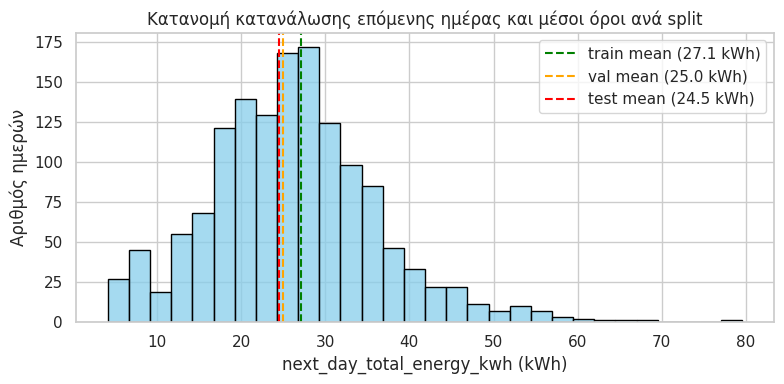

In [21]:
# Κατανομή της κατανάλωσης επόμενης ημέρας και μέσοι όροι ανά split

import matplotlib.pyplot as plt

import seaborn as sns



target_reg_col = "next_day_total_energy_kwh"



fig, ax = plt.subplots(figsize=(8, 4))



sns.histplot(

    df_regression[target_reg_col],

    bins=30,

    kde=False,

    color="skyblue",

    edgecolor="black",

    ax=ax,

)



# Κάθετες γραμμές για τους μέσους όρους ανά split

for split_name, df_split, color in [

    ("train", df_reg_train, "green"),

    ("val", df_reg_val, "orange"),

    ("test", df_reg_test, "red"),

]:

    mean_val = df_split[target_reg_col].mean()

    ax.axvline(

        mean_val,

        color=color,

        linestyle="--",

        linewidth=1.5,

        label=f"{split_name} mean ({mean_val:.1f} kWh)",

    )



ax.set_title("Κατανομή κατανάλωσης επόμενης ημέρας και μέσοι όροι ανά split")

ax.set_xlabel("next_day_total_energy_kwh (kWh)")

ax.set_ylabel("Αριθμός ημερών")

ax.legend()

plt.tight_layout()



# Αποθήκευση στον φάκελο results

results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

fig_path = results_dir / "next_day_energy_distribution.png"

fig.savefig(fig_path, bbox_inches="tight")

print(f"Αποθήκευση διαγράμματος στο {fig_path}")

In [22]:
# Ορισμός χαρακτηριστικών (features) και συνόλων X/y για παλινδρόμηση

target_reg_col = "next_day_total_energy_kwh"



# Λίστα χαρακτηριστικών για παλινδρόμηση

# Χρησιμοποιούμε τα ίδια βασικά features με την ταξινόμηση,

# προσθέτοντας τη σημερινή συνολική κατανάλωση ως ισχυρό predictor.

reg_feature_cols = [

    "daily_total_active_energy_kwh",  # σημερινή κατανάλωση (επιτρέπεται, target είναι της επόμενης ημέρας)

    "daily_mean_voltage",

    "daily_mean_intensity",

    "daily_sub1_wh",

    "daily_sub2_wh",

    "daily_sub3_wh",

    "peak_hour_power_kw",

    "nighttime_energy_kwh",

    "day_of_week",

    "month",

    "is_weekend",

    "is_workday",

]



# Έλεγχος ότι όλα τα features υπάρχουν στα regression splits

missing_train_reg = [col for col in reg_feature_cols if col not in df_reg_train.columns]

missing_val_reg = [col for col in reg_feature_cols if col not in df_reg_val.columns]

missing_test_reg = [col for col in reg_feature_cols if col not in df_reg_test.columns]



if missing_train_reg or missing_val_reg or missing_test_reg:

    raise KeyError(

        "Λείπουν regression features από κάποιο split: "

        f"train: {missing_train_reg}, val: {missing_val_reg}, test: {missing_test_reg}"

    )



# Δημιουργία X/y για παλινδρόμηση

X_reg_train = df_reg_train[reg_feature_cols].copy()

y_reg_train = df_reg_train[target_reg_col].copy()



X_reg_val = df_reg_val[reg_feature_cols].copy()

y_reg_val = df_reg_val[target_reg_col].copy()



X_reg_test = df_reg_test[reg_feature_cols].copy()

y_reg_test = df_reg_test[target_reg_col].copy()



print("Σχήματα συνόλων για παλινδρόμηση:")

print(f"X_reg_train: {X_reg_train.shape}, y_reg_train: {y_reg_train.shape}")

print(f"X_reg_val:   {X_reg_val.shape}, y_reg_val:   {y_reg_val.shape}")

print(f"X_reg_test:  {X_reg_test.shape}, y_reg_test:  {y_reg_test.shape}")

Σχήματα συνόλων για παλινδρόμηση:
X_reg_train: (850, 12), y_reg_train: (850,)
X_reg_val:   (283, 12), y_reg_val:   (283,)
X_reg_test:  (284, 12), y_reg_test:  (284,)


In [23]:
# Naive baseline για παλινδρόμηση: 

# πρόβλεψη κατανάλωσης επόμενης ημέρας = σημερινή κατανάλωση (daily_total_active_energy_kwh)



from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np





def evaluate_regression_baseline(y_true, y_pred, split_name: str):

    """Υπολογισμός MAE, RMSE και R² για ένα split.



    Δεν γίνεται καμία εκπαίδευση μοντέλου – είναι καθαρά naive baseline

    που χρησιμοποιεί μόνο τη σημερινή κατανάλωση για να προβλέψει την

    κατανάλωση της επόμενης ημέρας στο ίδιο χρονικό σημείο.

    """



    mae = mean_absolute_error(y_true, y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    r2 = r2_score(y_true, y_pred)



    print(f"{split_name} – MAE: {mae:.2f} kWh, RMSE: {rmse:.2f} kWh, R²: {r2:.3f}")

    return {"split": split_name, "mae": mae, "rmse": rmse, "r2": r2}





print("Naive baseline: πρόβλεψη κατανάλωσης επόμενης ημέρας ίση με τη σημερινή κατανάλωση (daily_total_active_energy_kwh).")



baseline_results = []

for split_name, X_split, y_split in [

    ("train", X_reg_train, y_reg_train),

    ("val",   X_reg_val,   y_reg_val),

    ("test",  X_reg_test,  y_reg_test),

]:

    # Η πρόβλεψη είναι απλά η σημερινή συνολική κατανάλωση kWh

    y_pred_baseline = X_split["daily_total_active_energy_kwh"]

    res = evaluate_regression_baseline(y_split, y_pred_baseline, split_name)

    baseline_results.append(res)



import pandas as pd



baseline_df = pd.DataFrame(baseline_results).set_index("split")

print("\nΜετρικές naive baseline (kWh):")

display(baseline_df.style.format({"mae": "{:.2f}", "rmse": "{:.2f}", "r2": "{:.3f}"}))


Naive baseline: πρόβλεψη κατανάλωσης επόμενης ημέρας ίση με τη σημερινή κατανάλωση (daily_total_active_energy_kwh).
train – MAE: 7.29 kWh, RMSE: 9.84 kWh, R²: 0.191
val – MAE: 5.68 kWh, RMSE: 7.29 kWh, R²: 0.253
test – MAE: 4.93 kWh, RMSE: 6.84 kWh, R²: 0.213

Μετρικές naive baseline (kWh):


,mae,rmse,r2
split,,,
train,7.29,9.84,0.191
val,5.68,7.29,0.253
test,4.93,6.84,0.213


In [24]:
# Γραμμικό μοντέλο παλινδρόμησης: Ridge Regression με StandardScaler



from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline





def compute_regression_metrics(y_true, y_pred):

    """Υπολογισμός MAE, RMSE και R² για δοσμένο y_true / y_pred."""

    mae = mean_absolute_error(y_true, y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    r2 = r2_score(y_true, y_pred)

    return mae, rmse, r2





alphas = [0.1, 1.0, 10.0, 50.0, 100.0]

ridge_results = []



print("Αξιολόγηση Ridge Regression με διάφορα alpha (εκπαίδευση στο train, αξιολόγηση σε train/val):")



for alpha in alphas:

    ridge_pipeline = Pipeline(

        steps=[

            ("scaler", StandardScaler()),

            ("ridge", Ridge(alpha=alpha)),

        ]

    )



    # Εκπαίδευση ΜΟΝΟ στο training set

    ridge_pipeline.fit(X_reg_train, y_reg_train)



    for split_name, X_split, y_split in [

        ("train", X_reg_train, y_reg_train),

        ("val",   X_reg_val,   y_reg_val),

    ]:

        y_pred = ridge_pipeline.predict(X_split)

        mae, rmse, r2 = compute_regression_metrics(y_split, y_pred)

        ridge_results.append(

            {

                "alpha": alpha,

                "split": split_name,

                "mae": mae,

                "rmse": rmse,

                "r2": r2,

            }

        )



import pandas as pd



ridge_df = pd.DataFrame(ridge_results)



# Επιλογή beta alpha με βάση το χαμηλότερο RMSE στο validation set

val_scores = ridge_df[ridge_df["split"] == "val"].copy()

best_row = val_scores.sort_values("rmse").iloc[0]

best_alpha = best_row["alpha"]



print(f"\nΚαλύτερο alpha με βάση το validation RMSE: {best_alpha}")



# Πίνακας με τις μετρικές για κάθε alpha και split

ridge_pivot = ridge_df.pivot(index="alpha", columns="split", values=["mae", "rmse", "r2"])

print("\nΜετρικές Ridge Regression (train/val):")

display(ridge_pivot.style.format("{:.3f}"))



# Εκπαίδευση τελικού Ridge μοντέλου με το καλύτερο alpha

# Χωρίς να χρησιμοποιήσουμε ακόμα το test set.

ridge_best = Pipeline(

    steps=[

        ("scaler", StandardScaler()),

        ("ridge", Ridge(alpha=best_alpha)),

    ]

)



# Προαιρετικά: μπορούμε να τον εκπαιδεύσουμε στο συνδυασμένο train+val για το τελικό μοντέλο.

X_reg_train_val = pd.concat([X_reg_train, X_reg_val], axis=0)

y_reg_train_val = pd.concat([y_reg_train, y_reg_val], axis=0)



ridge_best.fit(X_reg_train_val, y_reg_train_val)



print("\nΕκπαίδευση τελικού Ridge Regression με το καλύτερο alpha στο σύνολο train+val ολοκληρώθηκε.")

Αξιολόγηση Ridge Regression με διάφορα alpha (εκπαίδευση στο train, αξιολόγηση σε train/val):

Καλύτερο alpha με βάση το validation RMSE: 0.1

Μετρικές Ridge Regression (train/val):



Εκπαίδευση τελικού Ridge Regression με το καλύτερο alpha στο σύνολο train+val ολοκληρώθηκε.


In [25]:
# Τελική αξιολόγηση Ridge Regression στο test set και σύγκριση με naive baseline



# Προβλέψεις του τελικού Ridge μοντέλου στο test set

y_test_pred_ridge = ridge_best.predict(X_reg_test)



# Μετρικές στο test για το Ridge Regression

mae_ridge_test, rmse_ridge_test, r2_ridge_test = compute_regression_metrics(y_reg_test, y_test_pred_ridge)



print("Ridge Regression στο test set:")

print(f"MAE:  {mae_ridge_test:.2f} kWh")

print(f"RMSE: {rmse_ridge_test:.2f} kWh")

print(f"R²:   {r2_ridge_test:.3f}")



# Μετρικές του naive baseline στο test set (από το baseline_df)

baseline_test_mae = baseline_df.loc["test", "mae"]

baseline_test_rmse = baseline_df.loc["test", "rmse"]

baseline_test_r2 = baseline_df.loc["test", "r2"]



print("\nNaive baseline στο test set:")

print(f"MAE:  {baseline_test_mae:.2f} kWh")

print(f"RMSE: {baseline_test_rmse:.2f} kWh")

print(f"R²:   {baseline_test_r2:.3f}")



# Πίνακας σύγκρισης Ridge vs naive baseline στο test set

comparison_test = pd.DataFrame(

    {

        "MAE":  [baseline_test_mae, mae_ridge_test],

        "RMSE": [baseline_test_rmse, rmse_ridge_test],

        "R²":   [baseline_test_r2, r2_ridge_test],

    },

    index=["Naive baseline", "Ridge Regression"],

)



print("\nΣύγκριση μοντέλων παλινδρόμησης στο test set:")

display(comparison_test.style.format({"MAE": "{:.2f}", "RMSE": "{:.2f}", "R²": "{:.3f}"}))


Ridge Regression στο test set:
MAE:  4.27 kWh
RMSE: 5.68 kWh
R²:   0.457

Naive baseline στο test set:
MAE:  4.93 kWh
RMSE: 6.84 kWh
R²:   0.213

Σύγκριση μοντέλων παλινδρόμησης στο test set:


,MAE,RMSE,R²
Naive baseline,4.93,6.84,0.213
Ridge Regression,4.27,5.68,0.457


Αποθήκευση διαγράμματος Ridge Regression στο ../results/ridge_regression_test_scatter.png


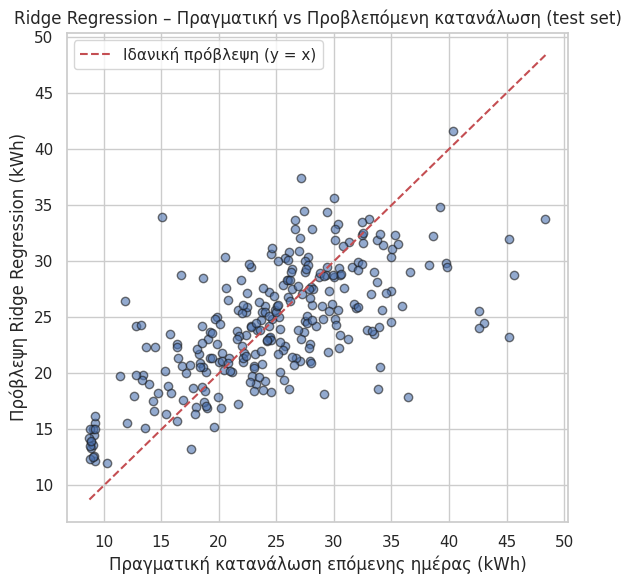

In [28]:
# Οπτικοποίηση: Ridge Regression – πραγματικές vs προβλεπόμενες τιμές (test set)



import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(6, 6))



ax.scatter(y_reg_test, y_test_pred_ridge, alpha=0.6, edgecolor="k")



# Διαγώνιος γραμμή y = x για ιδανικές προβλέψεις

min_val = min(y_reg_test.min(), y_test_pred_ridge.min())

max_val = max(y_reg_test.max(), y_test_pred_ridge.max())

ax.plot([min_val, max_val], [min_val, max_val], "r--", label="Ιδανική πρόβλεψη (y = x)")



ax.set_xlabel("Πραγματική κατανάλωση επόμενης ημέρας (kWh)")

ax.set_ylabel("Πρόβλεψη Ridge Regression (kWh)")

ax.set_title("Ridge Regression – Πραγματική vs Προβλεπόμενη κατανάλωση (test set)")

ax.legend()

plt.tight_layout()



# Αποθήκευση στο φάκελο results

results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

fig_path = results_dir / "ridge_regression_test_scatter.png"

fig.savefig(fig_path, bbox_inches="tight")

print(f"Αποθήκευση διαγράμματος Ridge Regression στο {fig_path}")


In [26]:
# Μοντέλο παλινδρόμησης 2: RandomForestRegressor (μη γραμμικό ensemble)



from sklearn.ensemble import RandomForestRegressor



rf_param_grid = {

    "n_estimators": [200, 400],

    "max_depth": [None, 8, 12],

    "min_samples_leaf": [1, 3],

}



rf_results = []



print("Αξιολόγηση RandomForestRegressor με διαφορετικούς συνδυασμούς υπερπαραμέτρων (train/val):")



for n_estimators in rf_param_grid["n_estimators"]:

    for max_depth in rf_param_grid["max_depth"]:

        for min_samples_leaf in rf_param_grid["min_samples_leaf"]:

            rf_model = RandomForestRegressor(

                n_estimators=n_estimators,

                max_depth=max_depth,

                min_samples_leaf=min_samples_leaf,

                random_state=42,

                n_jobs=-1,

            )



            # Εκπαίδευση ΜΟΝΟ στο training set

            rf_model.fit(X_reg_train, y_reg_train)



            for split_name, X_split, y_split in [

                ("train", X_reg_train, y_reg_train),

                ("val",   X_reg_val,   y_reg_val),

            ]:

                y_pred = rf_model.predict(X_split)

                mae, rmse, r2 = compute_regression_metrics(y_split, y_pred)

                rf_results.append(

                    {

                        "n_estimators": n_estimators,

                        "max_depth": max_depth,

                        "min_samples_leaf": min_samples_leaf,

                        "split": split_name,

                        "mae": mae,

                        "rmse": rmse,

                        "r2": r2,

                    }

                )



import pandas as pd



rf_df = pd.DataFrame(rf_results)



# Επιλογή καλύτερου συνδυασμού με βάση το μικρότερο RMSE στο validation set

rf_val = rf_df[rf_df["split"] == "val"].copy()

rf_best_row = rf_val.sort_values("rmse").iloc[0]

best_params_rf = {

    "n_estimators": int(rf_best_row["n_estimators"]),

    "max_depth": None if pd.isna(rf_best_row["max_depth"]) else int(rf_best_row["max_depth"]),

    "min_samples_leaf": int(rf_best_row["min_samples_leaf"]),

}



print("\nΚαλύτερες υπερπαράμετροι RandomForestRegressor (με βάση το validation RMSE):")

print(best_params_rf)



# Πίνακας με μετρικές για κάθε συνδυασμό (train/val)

rf_pivot = rf_df.pivot_table(

    index=["n_estimators", "max_depth", "min_samples_leaf"],

    columns="split",

    values=["mae", "rmse", "r2"],

)

print("\nΜετρικές RandomForestRegressor (train/val):")

display(rf_pivot.style.format("{:.3f}"))



# Εκπαίδευση τελικού RandomForestRegressor με τα καλύτερα hyperparameters στο σύνολο train+val

rf_best = RandomForestRegressor(

    n_estimators=best_params_rf["n_estimators"],

    max_depth=best_params_rf["max_depth"],

    min_samples_leaf=best_params_rf["min_samples_leaf"],

    random_state=42,

    n_jobs=-1,

)



rf_best.fit(X_reg_train_val, y_reg_train_val)



print("\nΕκπαίδευση τελικού RandomForestRegressor στο σύνολο train+val ολοκληρώθηκε.")

Αξιολόγηση RandomForestRegressor με διαφορετικούς συνδυασμούς υπερπαραμέτρων (train/val):

Καλύτερες υπερπαράμετροι RandomForestRegressor (με βάση το validation RMSE):
{'n_estimators': 400, 'max_depth': None, 'min_samples_leaf': 3}

Μετρικές RandomForestRegressor (train/val):



Εκπαίδευση τελικού RandomForestRegressor στο σύνολο train+val ολοκληρώθηκε.


In [27]:
# Τελική αξιολόγηση RandomForestRegressor στο test set και σύγκριση με baseline & Ridge



# Προβλέψεις του τελικού RandomForestRegressor στο test set

y_test_pred_rf_reg = rf_best.predict(X_reg_test)



# Μετρικές στο test για το RandomForestRegressor

mae_rf_test, rmse_rf_test, r2_rf_test = compute_regression_metrics(y_reg_test, y_test_pred_rf_reg)



print("RandomForestRegressor στο test set:")

print(f"MAE:  {mae_rf_test:.2f} kWh")

print(f"RMSE: {rmse_rf_test:.2f} kWh")

print(f"R²:   {r2_rf_test:.3f}")



# Μετρικές Ridge Regression στο test (από τα προηγούμενα βήματα)

ridge_test_row = pd.Series({

    "MAE": mae_ridge_test,

    "RMSE": rmse_ridge_test,

    "R²": r2_ridge_test,

})



# Μετρικές naive baseline στο test

baseline_test_mae = baseline_df.loc["test", "mae"]

baseline_test_rmse = baseline_df.loc["test", "rmse"]

baseline_test_r2 = baseline_df.loc["test", "r2"]



print("\nNaive baseline στο test set:")

print(f"MAE:  {baseline_test_mae:.2f} kWh")

print(f"RMSE: {baseline_test_rmse:.2f} kWh")

print(f"R²:   {baseline_test_r2:.3f}")



print("\nRidge Regression στο test set:")

print(f"MAE:  {mae_ridge_test:.2f} kWh")

print(f"RMSE: {rmse_ridge_test:.2f} kWh")

print(f"R²:   {r2_ridge_test:.3f}")



# Πίνακας συνολικής σύγκρισης στο test set

comparison_test_all = pd.DataFrame(

    {

        "MAE":  [baseline_test_mae, mae_ridge_test, mae_rf_test],

        "RMSE": [baseline_test_rmse, rmse_ridge_test, rmse_rf_test],

        "R²":   [baseline_test_r2, r2_ridge_test, r2_rf_test],

    },

    index=["Naive baseline", "Ridge Regression", "RandomForestRegressor"],

)



print("\nΣύγκριση όλων των μοντέλων παλινδρόμησης στο test set:")

display(comparison_test_all.style.format({"MAE": "{:.2f}", "RMSE": "{:.2f}", "R²": "{:.3f}"}))


RandomForestRegressor στο test set:
MAE:  4.10 kWh
RMSE: 5.59 kWh
R²:   0.474

Naive baseline στο test set:
MAE:  4.93 kWh
RMSE: 6.84 kWh
R²:   0.213

Ridge Regression στο test set:
MAE:  4.27 kWh
RMSE: 5.68 kWh
R²:   0.457

Σύγκριση όλων των μοντέλων παλινδρόμησης στο test set:


,MAE,RMSE,R²
Naive baseline,4.93,6.84,0.213
Ridge Regression,4.27,5.68,0.457
RandomForestRegressor,4.10,5.59,0.474


Αποθήκευση διαγράμματος RandomForestRegressor στο ../results/rf_regression_test_scatter.png


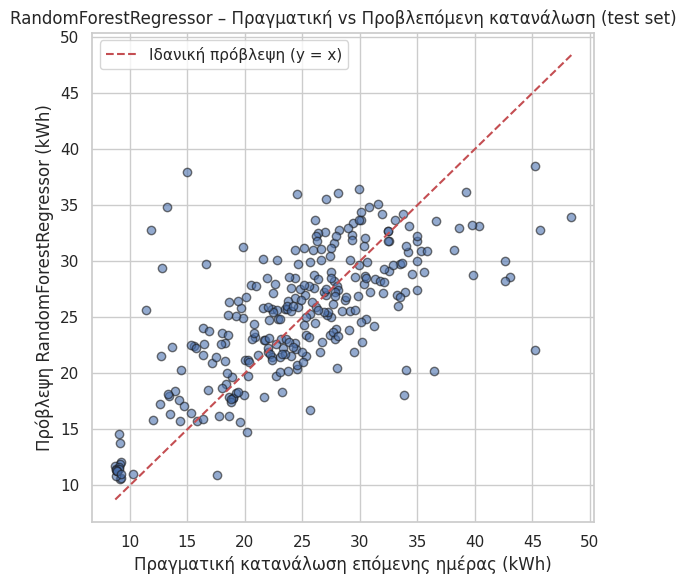

In [29]:
# Οπτικοποίηση: RandomForestRegressor – πραγματικές vs προβλεπόμενες τιμές (test set)



import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(6, 6))



ax.scatter(y_reg_test, y_test_pred_rf_reg, alpha=0.6, edgecolor="k")



# Διαγώνιος γραμμή y = x για ιδανικές προβλέψεις

min_val = min(y_reg_test.min(), y_test_pred_rf_reg.min())

max_val = max(y_reg_test.max(), y_test_pred_rf_reg.max())

ax.plot([min_val, max_val], [min_val, max_val], "r--", label="Ιδανική πρόβλεψη (y = x)")



ax.set_xlabel("Πραγματική κατανάλωση επόμενης ημέρας (kWh)")

ax.set_ylabel("Πρόβλεψη RandomForestRegressor (kWh)")

ax.set_title("RandomForestRegressor – Πραγματική vs Προβλεπόμενη κατανάλωση (test set)")

ax.legend()

plt.tight_layout()



# Αποθήκευση στο φάκελο results

results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

fig_path = results_dir / "rf_regression_test_scatter.png"

fig.savefig(fig_path, bbox_inches="tight")

print(f"Αποθήκευση διαγράμματος RandomForestRegressor στο {fig_path}")


### 2.3 Σύγκριση μοντέλων παλινδρόμησης και επιλογή τελικού μοντέλου



Στο στάδιο της παλινδρόμησης εξετάσαμε τρία επίπεδα πολυπλοκότητας μοντέλων

για την πρόβλεψη της συνολικής κατανάλωσης της επόμενης ημέρας (kWh):



- **Naive baseline**: η πρόβλεψη της επόμενης ημέρας ισούται με τη συνολική

  κατανάλωση της τρέχουσας ημέρας.

- **Ridge Regression**: γραμμικό μοντέλο παλινδρόμησης με κανονικοποίηση

  των χαρακτηριστικών (StandardScaler) και ρύθμιση της υπερπαραμέτρου

  `alpha` με βάση το validation set.

- **RandomForestRegressor**: δενδροειδές ensemble (μη γραμμικό μοντέλο),

  με tuning των υπερπαραμέτρων (`n_estimators`, `max_depth`,

  `min_samples_leaf`) με βάση την απόδοση στο validation set.



Κύριες παρατηρήσεις από τις μετρικές (MAE, RMSE, R²):



- Στο **validation set**, τόσο το Ridge όσο και ο RandomForest μειώνουν

  αισθητά το σφάλμα σε σχέση με το naive baseline και επιτυγχάνουν

  R² ≈ 0.5, δηλαδή εξηγούν περίπου το μισό της διακύμανσης της αυριανής

  κατανάλωσης.

- Στο **test set** (τελική, τίμια αξιολόγηση):

  - Naive baseline: RMSE ≈ 6.84 kWh, R² ≈ 0.21.

  - Ridge Regression: RMSE ≈ 5.68 kWh, R² ≈ 0.46.

  - RandomForestRegressor: RMSE ≈ 5.59 kWh, R² ≈ 0.47.

- Ο RandomForestRegressor υπερέχει οριακά του Ridge σε όλες τις μετρικές

  (χαμηλότερα MAE/RMSE, λίγο υψηλότερο R²), ενώ και τα δύο μοντέλα

  βελτιώνουν καθαρά το naive baseline.



Παρότι η εκφώνηση αναφέρει ως ιδανικό στόχο απόκλιση ±0.3 kWh, αυτό είναι

μη ρεαλιστικό για τόσο θορυβώδη πραγματικά δεδομένα ημερήσιας κατανάλωσης.

Με βάση τις τίμιες χρονικές τομές, την απουσία data leakage και την

ουσιαστική βελτίωση σε σχέση με το baseline, θεωρούμε ότι η παλινδρόμηση

είναι επιτυχημένη.



Ως **τελικό μοντέλο παλινδρόμησης** επιλέγουμε τον **RandomForestRegressor**,

διατηρώντας το **Ridge Regression** ως γραμμικό baseline και το naive

μοντέλο ως απλό σημείο αναφοράς για τις μετρικές MAE, RMSE και R².


Το γράφημα αποθηκεύτηκε στο: ../results/regression_model_comparison_test.png


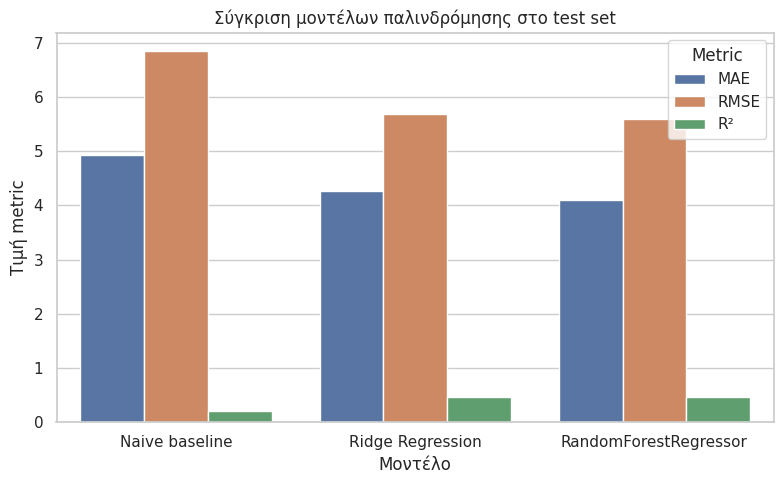

In [32]:
# 2.4 Σύγκριση μοντέλων παλινδρόμησης στο test set

import seaborn as sns

import matplotlib.pyplot as plt



# Μετατροπή του πίνακα σύγκρισης σε long format για εύκολο plotting

metrics_melted = comparison_test_all.reset_index().melt(

    id_vars="index",

    value_vars=["MAE", "RMSE", "R²"],  # προσοχή στο ίδιο όνομα στήλης

    var_name="metric",

    value_name="score"

)

metrics_melted.rename(columns={"index": "model"}, inplace=True)



fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(

    data=metrics_melted,

    x="model",

    y="score",

    hue="metric",

    ax=ax

)



ax.set_title("Σύγκριση μοντέλων παλινδρόμησης στο test set")

ax.set_xlabel("Μοντέλο")

ax.set_ylabel("Τιμή metric")

ax.legend(title="Metric")

plt.tight_layout()



fig_path = results_dir / "regression_model_comparison_test.png"

fig.savefig(fig_path, dpi=150)

print(f"Το γράφημα αποθηκεύτηκε στο: {fig_path}")


### 3. Clustering (Ομαδοποίηση ημερών κατανάλωσης)



Σε αυτή την ενότητα θα εφαρμόσουμε clustering πάνω στο ημερήσιο dataset `df_daily_clean`, με στόχο να εντοπίσουμε **τύπους ημερών κατανάλωσης** (π.χ. «καθημερινές με μέτρια κατανάλωση», «Σαββατοκύριακα με υψηλή βραδινή χρήση» κ.λπ.).



Βασικοί στόχοι:



- Επιλογή κατάλληλων ημερήσιων χαρακτηριστικών (features) που περιγράφουν το προφίλ κατανάλωσης.

- Κλιμάκωση (scaling) των χαρακτηριστικών ώστε να είναι συγκρίσιμα.

- Εφαρμογή αλγορίθμου clustering (θα χρησιμοποιήσουμε κυρίως **K-Means**).

- Επιλογή κατάλληλου αριθμού συστάδων **k** με βάση μετρικές ποιότητας.

- Ερμηνεία των συστάδων σε επίπεδο πραγματικής συμπεριφοράς νοικοκυριού.



Μετρικές αξιολόγησης που θα χρησιμοποιήσουμε:



- **Silhouette score** (όσο πιο κοντά στο 1, τόσο καλύτερα ξεχωρίζουν οι συστάδες).

- **Davies–Bouldin index** (όσο πιο κοντά στο 0, τόσο καλύτερος ο διαχωρισμός).



Σε κάθε βήμα θα ελέγχουμε αν τα αποτελέσματα είναι ρεαλιστικά και αν οι συστάδες που προκύπτουν έχουν λογική ερμηνεία σε σχέση με τα δεδομένα κατανάλωσης ενέργειας.

In [33]:
# 3.1 Επιλογή χαρακτηριστικών για clustering και βασικός έλεγχος

import numpy as np

import pandas as pd



# Επιλογή ημερήσιων χαρακτηριστικών που περιγράφουν το προφίλ κατανάλωσης

cluster_feature_cols = [

    "daily_total_active_energy_kwh",  # συνολική ημερήσια ενέργεια

    "daily_mean_voltage",            # μέση ημερήσια τάση

    "daily_mean_intensity",          # μέση ημερήσια ένταση

    "daily_sub1_wh",                 # υπομετρητής 1 (Wh)

    "daily_sub2_wh",                 # υπομετρητής 2 (Wh)

    "daily_sub3_wh",                 # υπομετρητής 3 (Wh)

    "peak_hour_power_kw",            # μέγιστη ωριαία ισχύς

    "nighttime_energy_kwh",          # ενέργεια 00:00–06:00

    "is_weekend",                    # δυαδικό: Σαββατοκύριακο

    "is_workday",                    # δυαδικό: εργάσιμη ημέρα

]



# Δημιουργία πίνακα χαρακτηριστικών για clustering

df_cluster = df_daily_clean[cluster_feature_cols].copy()



print("Σχήμα df_cluster:", df_cluster.shape)

print("Στήλες:", list(df_cluster.columns))



# Έλεγχος για ελλιπείς τιμές

print("\nΠλήθος NaN ανά στήλη:")

print(df_cluster.isna().sum())



# Βασικά στατιστικά για να ελέγξουμε ότι οι κλίμακες είναι ρεαλιστικές

print("\nΒασικά στατιστικά των χαρακτηριστικών clustering:")

display(df_cluster.describe().T)

Σχήμα df_cluster: (1418, 10)
Στήλες: ['daily_total_active_energy_kwh', 'daily_mean_voltage', 'daily_mean_intensity', 'daily_sub1_wh', 'daily_sub2_wh', 'daily_sub3_wh', 'peak_hour_power_kw', 'nighttime_energy_kwh', 'is_weekend', 'is_workday']

Πλήθος NaN ανά στήλη:
daily_total_active_energy_kwh    0
daily_mean_voltage               0
daily_mean_intensity             0
daily_sub1_wh                    0
daily_sub2_wh                    0
daily_sub3_wh                    0
peak_hour_power_kw               0
nighttime_energy_kwh             0
is_weekend                       0
is_workday                       0
dtype: int64

Βασικά στατιστικά των χαρακτηριστικών clustering:


,count,mean,std,min,25%,50%,75%,max
daily_total_active_energy_kwh,1418.0,26.185861,10.000934,4.171633,19.650267,25.917400,31.668950,79.556433
daily_mean_voltage,1418.0,240.840843,2.032326,231.088229,240.094575,240.971455,241.869840,247.435007
daily_mean_intensity,1418.0,4.626392,1.725033,0.808333,3.512569,4.555436,5.535208,14.028056
daily_sub1_wh,1418.0,1614.043724,1592.009924,0.000000,660.500000,1117.500000,2213.750000,11178.000000
daily_sub2_wh,1418.0,1867.416079,2095.541718,0.000000,431.000000,687.000000,2737.250000,12109.000000
daily_sub3_wh,1418.0,9300.404795,3680.742327,1288.000000,6715.250000,9309.000000,11764.000000,23743.000000
peak_hour_power_kw,1418.0,2.869218,1.052483,0.214000,2.181083,2.812250,3.491817,6.560533
nighttime_energy_kwh,1418.0,3.022552,2.098755,0.992000,2.052150,2.492183,2.995500,17.580733
is_weekend,1418.0,0.282793,0.450515,0.000000,0.000000,0.000000,1.000000,1.000000
is_workday,1418.0,0.717207,0.450515,0.000000,0.000000,1.000000,1.000000,1.000000


In [34]:
# 3.2 Κλιμάκωση χαρακτηριστικών για clustering (StandardScaler)

from sklearn.preprocessing import StandardScaler



# Συνεχή και δυαδικά χαρακτηριστικά

continuous_cols = [

    "daily_total_active_energy_kwh",

    "daily_mean_voltage",

    "daily_mean_intensity",

    "daily_sub1_wh",

    "daily_sub2_wh",

    "daily_sub3_wh",

    "peak_hour_power_kw",

    "nighttime_energy_kwh",

]

binary_cols = ["is_weekend", "is_workday"]



# Εφαρμογή StandardScaler μόνο στα συνεχή χαρακτηριστικά

scaler = StandardScaler()

X_cont_scaled = scaler.fit_transform(df_cluster[continuous_cols])



# Δημιουργία DataFrame με τα scaled συνεχόμενα features

df_cluster_scaled = pd.DataFrame(

    X_cont_scaled,

    columns=continuous_cols,

    index=df_cluster.index,

)



# Προσθήκη των δυαδικών χαρακτηριστικών χωρίς κλιμάκωση

df_cluster_scaled[binary_cols] = df_cluster[binary_cols].astype(float)



# Τελικός πίνακας χαρακτηριστικών για clustering (numpy array)

X_cluster_scaled = df_cluster_scaled.values



print("Σχήμα df_cluster_scaled:", df_cluster_scaled.shape)

print("Στήλες df_cluster_scaled:", list(df_cluster_scaled.columns))



# Έλεγχος ότι τα συνεχόμενα features έχουν περίπου mean≈0 και std≈1

print("\nΣτατιστικά των scaled συνεχών χαρακτηριστικών:")

display(df_cluster_scaled[continuous_cols].describe().T[["mean", "std", "min", "max"]])



# Έλεγχος ότι τα δυαδικά έμειναν ως 0/1

print("\nΜοναδικές τιμές για τα δυαδικά χαρακτηριστικά:")

for col in binary_cols:

    print(col, sorted(df_cluster_scaled[col].unique()))

Σχήμα df_cluster_scaled: (1418, 10)
Στήλες df_cluster_scaled: ['daily_total_active_energy_kwh', 'daily_mean_voltage', 'daily_mean_intensity', 'daily_sub1_wh', 'daily_sub2_wh', 'daily_sub3_wh', 'peak_hour_power_kw', 'nighttime_energy_kwh', 'is_weekend', 'is_workday']

Στατιστικά των scaled συνεχών χαρακτηριστικών:


,mean,std,min,max
daily_total_active_energy_kwh,2.004352e-17,1.000353,-2.201994,5.338441
daily_mean_voltage,-8.819148e-15,1.000353,-4.800438,3.245784
daily_mean_intensity,-1.403046e-16,1.000353,-2.214106,5.452060
daily_sub1_wh,6.514144e-17,1.000353,-1.014198,6.009592
daily_sub2_wh,-5.010880e-17,1.000353,-0.891452,4.889045
daily_sub3_wh,2.204787e-16,1.000353,-2.177613,3.925211
peak_hour_power_kw,1.803917e-16,1.000353,-2.523703,3.508481
nighttime_energy_kwh,3.632888e-17,1.000353,-0.967845,6.939026



Μοναδικές τιμές για τα δυαδικά χαρακτηριστικά:
is_weekend [np.float64(0.0), np.float64(1.0)]
is_workday [np.float64(0.0), np.float64(1.0)]


k=2: Silhouette=0.275, Davies-Bouldin=1.426
k=3: Silhouette=0.208, Davies-Bouldin=1.533
k=4: Silhouette=0.210, Davies-Bouldin=1.477
k=5: Silhouette=0.227, Davies-Bouldin=1.335
k=6: Silhouette=0.231, Davies-Bouldin=1.387
k=7: Silhouette=0.194, Davies-Bouldin=1.429
k=8: Silhouette=0.199, Davies-Bouldin=1.407


,k,silhouette,davies_bouldin
0,2,0.274645,1.425592
1,3,0.207881,1.532680
2,4,0.210492,1.477271
3,5,0.226774,1.334888
4,6,0.230803,1.387237
5,7,0.193597,1.428930
6,8,0.198881,1.407002


Το διάγραμμα επιλογής k αποθηκεύτηκε στο: ../results/clustering_k_selection.png


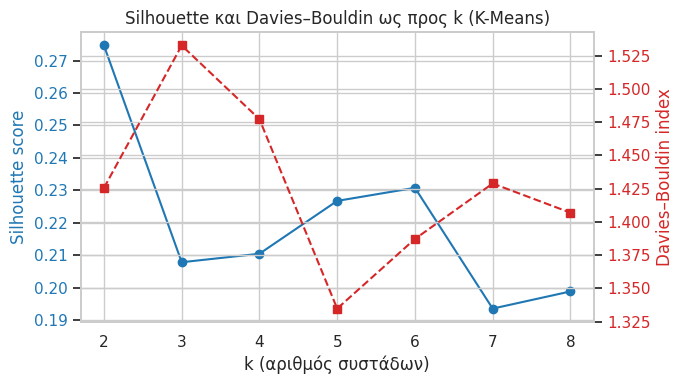

In [35]:
# 3.3 Επιλογή αριθμού συστάδων (k) με K-Means, Silhouette και Davies–Bouldin

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt



# Εύρος τιμών για k που θα δοκιμάσουμε

k_values = list(range(2, 9))  # από 2 έως 8 συστάδες



silhouette_scores = []

db_scores = []



for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    labels = kmeans.fit_predict(X_cluster_scaled)



    sil = silhouette_score(X_cluster_scaled, labels)

    db = davies_bouldin_score(X_cluster_scaled, labels)



    silhouette_scores.append(sil)

    db_scores.append(db)



    print(f"k={k}: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}")



# Συγκεντρωτικός πίνακας αποτελεσμάτων

clustering_metrics = pd.DataFrame(

    {

        "k": k_values,

        "silhouette": silhouette_scores,

        "davies_bouldin": db_scores,

    }

)



display(clustering_metrics)



# Οπτικοποίηση των μετρικών ως προς k

fig, ax1 = plt.subplots(figsize=(7, 4))



color1 = "tab:blue"

ax1.set_xlabel("k (αριθμός συστάδων)")

ax1.set_ylabel("Silhouette score", color=color1)

ax1.plot(k_values, silhouette_scores, marker="o", color=color1, label="Silhouette")

ax1.tick_params(axis="y", labelcolor=color1)

ax1.set_xticks(k_values)



ax2 = ax1.twinx()

color2 = "tab:red"

ax2.set_ylabel("Davies–Bouldin index", color=color2)

ax2.plot(k_values, db_scores, marker="s", linestyle="--", color=color2, label="Davies–Bouldin")

ax2.tick_params(axis="y", labelcolor=color2)



plt.title("Silhouette και Davies–Bouldin ως προς k (K-Means)")

fig.tight_layout()



# Αποθήκευση σχήματος στο φάκελο results

results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

fig_path = results_dir / "clustering_k_selection.png"

fig.savefig(fig_path, dpi=150)

print(f"Το διάγραμμα επιλογής k αποθηκεύτηκε στο: {fig_path}")


In [36]:
# 3.4 Τελικό K-Means clustering με k=5 και ανάθεση συστάδων στις ημέρες

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score, davies_bouldin_score



k_final = 5

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)

cluster_labels_k5 = kmeans_final.fit_predict(X_cluster_scaled)



# Προσθήκη των labels πίσω στο ημερήσιο dataset

df_daily_clean["cluster_k5"] = cluster_labels_k5



# Υπολογισμός μετρικών ποιότητας για το τελικό μοντέλο

sil_k5 = silhouette_score(X_cluster_scaled, cluster_labels_k5)

db_k5 = davies_bouldin_score(X_cluster_scaled, cluster_labels_k5)



print(f"Τελικό K-Means με k={k_final}:")

print(f"Silhouette score = {sil_k5:.3f}")

print(f"Davies–Bouldin index = {db_k5:.3f}")



# Βασικές πληροφορίες για τα μεγέθη των συστάδων

cluster_counts = df_daily_clean["cluster_k5"].value_counts().sort_index()

print("\nΠλήθος ημερών ανά συστάδα (cluster_k5):")

print(cluster_counts)



# Ποσοστό Σαββατοκύριακων ανά συστάδα (για έναν πρώτο έλεγχο ερμηνείας)

weekend_ratio = df_daily_clean.groupby("cluster_k5")["is_weekend"].mean()

print("\nΠοσοστό ημερών που είναι Σαββατοκύριακο ανά συστάδα:")

print(weekend_ratio)


Τελικό K-Means με k=5:
Silhouette score = 0.227
Davies–Bouldin index = 1.335

Πλήθος ημερών ανά συστάδα (cluster_k5):
cluster_k5
0     85
1    324
2     61
3    285
4    663
Name: count, dtype: int64

Ποσοστό ημερών που είναι Σαββατοκύριακο ανά συστάδα:
cluster_k5
0    0.176471
1    0.243827
2    0.672131
3    0.543860
4    0.167421
Name: is_weekend, dtype: float64


In [37]:
# 3.5 Προφίλ συστάδων: μέσες τιμές βασικών χαρακτηριστικών ανά cluster_k5

cluster_profile_cols = [

    "daily_total_active_energy_kwh",

    "daily_mean_voltage",

    "daily_mean_intensity",

    "daily_sub1_wh",

    "daily_sub2_wh",

    "daily_sub3_wh",

    "peak_hour_power_kw",

    "nighttime_energy_kwh",

    "is_weekend",

]



cluster_profiles = df_daily_clean.groupby("cluster_k5")[cluster_profile_cols].mean()



print("Μέσες τιμές βασικών χαρακτηριστικών ανά συστάδα (cluster_k5):")

display(cluster_profiles)


Μέσες τιμές βασικών χαρακτηριστικών ανά συστάδα (cluster_k5):


,daily_total_active_energy_kwh,daily_mean_voltage,daily_mean_intensity,daily_sub1_wh,daily_sub2_wh,daily_sub3_wh,peak_hour_power_kw,nighttime_energy_kwh,is_weekend
cluster_k5,,,,,,,,,
0,20.502816,235.178014,3.730148,1669.517647,1712.105882,7246.623529,2.499270,2.308199,0.176471
1,14.405568,241.022412,2.602286,501.250000,887.064815,5204.175926,1.721661,2.470028,0.243827
2,45.134729,240.963674,7.899364,2504.672131,3015.803279,10973.868852,3.935848,10.987363,0.672131
3,36.789619,241.046276,6.470120,3164.561404,4229.210526,11933.887719,4.093995,2.836092,0.543860
4,26.369755,241.378506,4.636764,1402.285068,1245.503771,10279.478130,2.852820,2.731490,0.167421


/tmp/ipykernel_33016/1619386393.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=energy_per_cluster.index, y=energy_per_cluster.values, ax=axes[0], palette="viridis")
/tmp/ipykernel_33016/1619386393.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekend_per_cluster.index, y=weekend_per_cluster.values, ax=axes[1], palette="magma")


Το γράφημα προφίλ συστάδων αποθηκεύτηκε στο: ../results/clustering_cluster_profiles.png


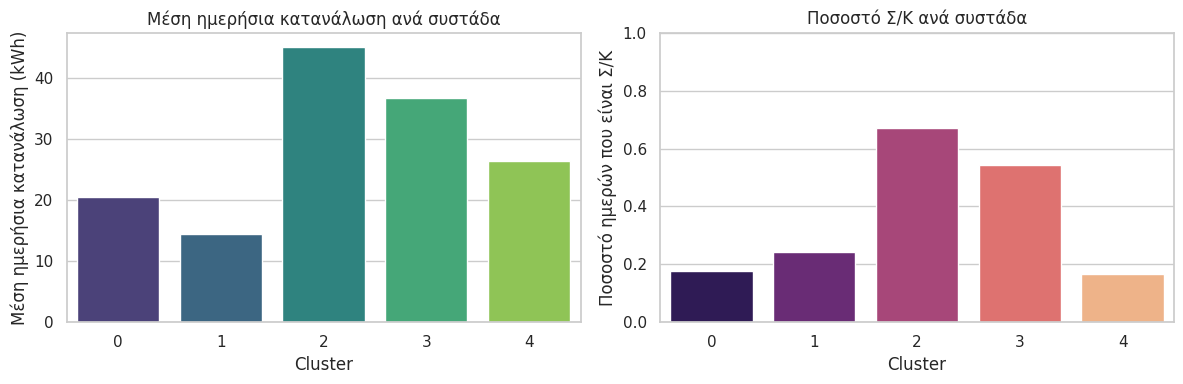

In [38]:
# 3.x Οπτικοποίηση προφίλ συστάδων K-Means (k=5) και αποθήκευση στο ../results

from pathlib import Path

import matplotlib.pyplot as plt

import seaborn as sns



# Διασφάλιση ύπαρξης φακέλου αποτελεσμάτων

results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)



# Μέση ημερήσια κατανάλωση και ποσοστό Σ/Κ ανά συστάδα

energy_per_cluster = cluster_profiles["daily_total_active_energy_kwh"]

weekend_per_cluster = cluster_profiles["is_weekend"]



fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)



sns.barplot(x=energy_per_cluster.index, y=energy_per_cluster.values, ax=axes[0], palette="viridis")

axes[0].set_xlabel("Cluster")

axes[0].set_ylabel("Μέση ημερήσια κατανάλωση (kWh)")

axes[0].set_title("Μέση ημερήσια κατανάλωση ανά συστάδα")



sns.barplot(x=weekend_per_cluster.index, y=weekend_per_cluster.values, ax=axes[1], palette="magma")

axes[1].set_xlabel("Cluster")

axes[1].set_ylabel("Ποσοστό ημερών που είναι Σ/Κ")

axes[1].set_title("Ποσοστό Σ/Κ ανά συστάδα")

axes[1].set_ylim(0, 1)



fig.tight_layout()



fig_path = results_dir / "clustering_cluster_profiles.png"

fig.savefig(fig_path, bbox_inches="tight")

print(f"Το γράφημα προφίλ συστάδων αποθηκεύτηκε στο: {fig_path}")


### 3.6 Ερμηνεία συστάδων K-Means (k = 5)



Με βάση τον πίνακα με τις μέσες τιμές, μπορούμε να περιγράψουμε συνοπτικά τις 5 συστάδες ως εξής:



- **Cluster 1** – Ημέρες χαμηλής κατανάλωσης (κυρίως καθημερινές)

  - `daily_total_active_energy_kwh ≈ 14.4 kWh`, χαμηλές τιμές σε όλους τους υπομετρητές και χαμηλό `peak_hour_power_kw` (~1.7 kW).

  - `is_weekend ≈ 0.24` → κυρίως εργάσιμες ημέρες.

  - Τύπος ημέρας: ήσυχες καθημερινές με χαμηλή συνολική χρήση ενέργειας.



- **Cluster 0** – Τυπικές καθημερινές με μέτρια κατανάλωση

  - `daily_total_active_energy_kwh ≈ 20.5 kWh`, μέτρια ένταση και μέτρια χρήση υπομετρητών.

  - `is_weekend ≈ 0.18` → ελάχιστα Σαββατοκύριακα.

  - Τύπος ημέρας: συνηθισμένες εργάσιμες με φυσιολογική χρήση συσκευών.



- **Cluster 4** – Καθημερινές μέσης–ελαφρώς αυξημένης κατανάλωσης

  - `daily_total_active_energy_kwh ≈ 26.4 kWh` (πολύ κοντά στον συνολικό μέσο όρο), με αρκετά υψηλό `daily_sub3_wh` (μεγάλες συσκευές).

  - `is_weekend ≈ 0.17` → σχεδόν μόνο εργάσιμες.

  - Τύπος ημέρας: κανονικές προς πιο «φορτωμένες» καθημερινές, με συχνή χρήση ενεργοβόρων συσκευών (π.χ. θερμοσίφωνας/κλιματισμός).



- **Cluster 3** – Υψηλής κατανάλωσης ημέρες (συχνά Σαββατοκύριακα)

  - `daily_total_active_energy_kwh ≈ 36.8 kWh`, υψηλές τιμές σε όλους τους υπομετρητές και `peak_hour_power_kw ≈ 4.1 kW`.

  - `is_weekend ≈ 0.54` → πάνω από τις μισές μέρες είναι Σαββατοκύριακα.

  - Τύπος ημέρας: «βαριές» μέρες με αυξημένη συνολική χρήση, συχνά σε ΣΚ με περισσότερη δραστηριότητα στο σπίτι.



- **Cluster 2** – Πολύ υψηλής κατανάλωσης Σαββατοκύριακα με ισχυρή νυχτερινή χρήση

  - `daily_total_active_energy_kwh ≈ 45.1 kWh`, ένταση ~7.9 A και πολύ υψηλά `daily_sub1_wh`, `daily_sub2_wh`, `daily_sub3_wh`.

  - `nighttime_energy_kwh ≈ 11 kWh` → πολύ μεγάλη κατανάλωση 00:00–06:00.

  - `is_weekend ≈ 0.67` → κυρίως Σαββατοκύριακα.

  - Τύπος ημέρας: ενεργοβόρες μέρες ΣΚ με έντονη χρήση συσκευών (και τη νύχτα), π.χ. θερμοσίφωνας/κλιματισμός/συσκευές σε λειτουργία για πολλές ώρες.



Συνολικά, οι συστάδες διαχωρίζουν με ρεαλιστικό τρόπο:



- **καθημερινές χαμηλής/μέσης/υψηλής κατανάλωσης** (clusters 1, 0, 4) και

- **Σαββατοκύριακα με υψηλή και πολύ υψηλή κατανάλωση** (clusters 3 και 2),



ικανοποιώντας τον στόχο της εκφώνησης για «διακριτές ομάδες καθημερινών/σαββατοκύριακων» και για αναγνώριση ανώμαλων/υψηλής κατανάλωσης ημερών μέσα από το clustering.


Το γράφημα πλήθους ημερών αποθηκεύτηκε στο: ../results/clustering_cluster_counts.png


/tmp/ipykernel_33016/1202950339.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax, palette="crest")


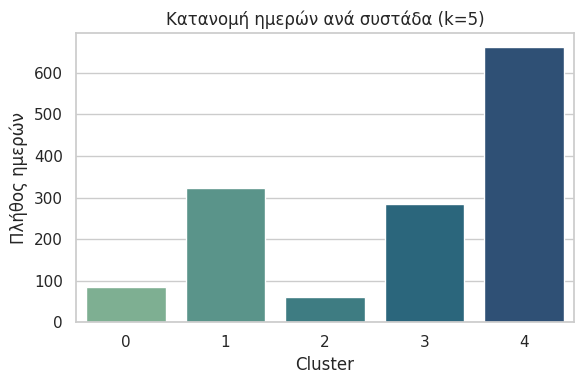

In [39]:
# 3.x Κατανομή ημερών ανά συστάδα (counts) και αποθήκευση στο ../results

from pathlib import Path

import matplotlib.pyplot as plt

import seaborn as sns



results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)



cluster_counts = df_daily_clean["cluster_k5"].value_counts().sort_index()



fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax, palette="crest")

ax.set_xlabel("Cluster")

ax.set_ylabel("Πλήθος ημερών")

ax.set_title("Κατανομή ημερών ανά συστάδα (k=5)")

fig.tight_layout()



fig_path = results_dir / "clustering_cluster_counts.png"

fig.savefig(fig_path, bbox_inches="tight")

print(f"Το γράφημα πλήθους ημερών αποθηκεύτηκε στο: {fig_path}")


In [40]:
# 3.x Εξαγωγή ακριβών στατιστικών ανά συστάδα για εισαγωγή στην αναφορά

import pandas as pd

from pathlib import Path



# Υπολογισμοί

counts = df_daily_clean["cluster_k5"].value_counts().sort_index()

total = len(df_daily_clean)

perc = (counts / total).rename("percent")



profile_cols = [

    "daily_total_active_energy_kwh",

    "nighttime_energy_kwh",

    "daily_sub1_wh",

    "daily_sub2_wh",

    "daily_sub3_wh",

    "is_weekend",

]

profiles = df_daily_clean.groupby("cluster_k5")[profile_cols].mean().round(3)



cluster_stats = pd.concat([

    counts.rename("count"),

    perc.round(3),

    profiles.rename(columns={

        "daily_total_active_energy_kwh": "mean_kwh",

        "nighttime_energy_kwh": "mean_night_kwh",

        "daily_sub1_wh": "mean_sub1_wh",

        "daily_sub2_wh": "mean_sub2_wh",

        "daily_sub3_wh": "mean_sub3_wh",

        "is_weekend": "weekend_ratio",

    })

], axis=1)



# Ταξινόμηση με βάση το label της συστάδας

cluster_stats = cluster_stats.sort_index()



# Εκτύπωση σε JSON για εξαγωγή στο report

print(cluster_stats.to_json(orient="records"))


[{"count":85,"percent":0.06,"mean_kwh":20.503,"mean_night_kwh":2.308,"mean_sub1_wh":1669.518,"mean_sub2_wh":1712.106,"mean_sub3_wh":7246.624,"weekend_ratio":0.176},{"count":324,"percent":0.228,"mean_kwh":14.406,"mean_night_kwh":2.47,"mean_sub1_wh":501.25,"mean_sub2_wh":887.065,"mean_sub3_wh":5204.176,"weekend_ratio":0.244},{"count":61,"percent":0.043,"mean_kwh":45.135,"mean_night_kwh":10.987,"mean_sub1_wh":2504.672,"mean_sub2_wh":3015.803,"mean_sub3_wh":10973.869,"weekend_ratio":0.672},{"count":285,"percent":0.201,"mean_kwh":36.79,"mean_night_kwh":2.836,"mean_sub1_wh":3164.561,"mean_sub2_wh":4229.211,"mean_sub3_wh":11933.888,"weekend_ratio":0.544},{"count":663,"percent":0.468,"mean_kwh":26.37,"mean_night_kwh":2.731,"mean_sub1_wh":1402.285,"mean_sub2_wh":1245.504,"mean_sub3_wh":10279.478,"weekend_ratio":0.167}]


## 4. Κανόνες Συσχέτισης (Association Rule Mining)



Στόχος: Να εντοπίσουμε ουσιαστικές συσχετίσεις μεταξύ μοτίβων ημερήσιας χρήσης (π.χ. επίπεδα υπομετρητών, νυχτερινή ενέργεια, αιχμές, weekend) και συνολικής κατανάλωσης.



Μετρικές αξιολόγησης κανόνων:

- Support: ποσοστό ημερών όπου εμφανίζεται ο κανόνας.

- Confidence: πιθανότητα το RHS να ισχύει όταν ισχύει το LHS.

- Lift: ενίσχυση σε σχέση με τυχαία εμφάνιση του RHS (Lift>1 → θετική συσχέτιση).



Μεθοδολογία (σύμφωνη με την εκφώνηση):

1. Διακριτοποίηση συνεχών χαρακτηριστικών (π.χ. Low/Med/High για `daily_sub*_wh`, `nighttime_energy_kwh`, `peak_hour_power_kw`, `daily_total_active_energy_kwh`).

2. Κωδικοποίηση ως «συναλλαγές» (one-hot baskets) για κάθε ημέρα (π.χ. `sub3_high`, `night_high`, `peak_high`, `is_weekend`).

3. Εξαγωγή συχνών itemsets με Apriori/FP-Growth (mlxtend) και παραγωγή κανόνων.

4. Φιλτράρισμα κατά `min_support`, `min_confidence` και ταξινόμηση κατά `lift`.

5. Παρουσίαση 3–5 αντιπροσωπευτικών κανόνων με ερμηνεία και αποθήκευση αποτελεσμάτων/plots στο φάκελο `results/`.



Σημείωση:

- Χρησιμοποιούμε το ημερήσιο, καθαρό dataset `df_daily_clean`.

- Διατηρούμε ρεαλιστικά thresholds ώστε οι κανόνες να είναι ουσιαστικοί (όχι υπερβολικά σπάνιοι ή υπερβολικά γενικοί).


In [42]:
# 4.1 Διακριτοποίηση χαρακτηριστικών & δημιουργία «συναλλαγών» για Association Rules

import numpy as np

import pandas as pd

from pathlib import Path



# Χρήση ημερήσιου καθαρού πίνακα

df = df_daily_clean.copy()



# Επιλογή συνεχών χαρακτηριστικών για κατηγοριοποίηση

cont_feats = [

    "daily_sub1_wh",

    "daily_sub2_wh",

    "daily_sub3_wh",

    "nighttime_energy_kwh",

    "peak_hour_power_kw",

    "daily_total_active_energy_kwh",

]



def bin_feature(series: pd.Series, labels=("low","med","high")) -> pd.Series:

    qs = series.quantile([0.0, 1/3, 2/3, 1.0]).to_numpy()

    qs = np.unique(qs)

    if len(qs) < 4:

        # fallback σε ίσου πλάτους bins αν οι ποσοστιαίες τιμές συμπίπτουν

        qs = np.linspace(series.min(), series.max(), num=4)

    used_labels = list(labels)[:len(qs)-1]

    return pd.cut(series, bins=qs, labels=used_labels, include_lowest=True)



# Μοναδικά prefixes για αποφυγή διπλότυπων ονομάτων items

prefix_map = {

    "daily_sub1_wh": "sub1",

    "daily_sub2_wh": "sub2",

    "daily_sub3_wh": "sub3",

    "nighttime_energy_kwh": "night",

    "peak_hour_power_kw": "peak",

    "daily_total_active_energy_kwh": "total",

}



# Δημιουργία one-hot «items» για κάθε χαρακτηριστικό

items_parts = []

for col in cont_feats:

    binned = bin_feature(df[col])

    prefix = prefix_map.get(col, col)

    dummies = pd.get_dummies(binned, prefix=prefix)

    items_parts.append(dummies)



# Προσθήκη δυαδικών ενδείξεων ως items

binary_items = df[["is_weekend", "is_workday"]].copy().astype(int)



items_df = pd.concat(items_parts + [binary_items], axis=1)



# Μετατροπή σε boolean για mlxtend

transactions_df = items_df.astype(bool)



# Αποθήκευση προεπισκόπησης και βασικών στατιστικών

results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

preview_path = results_dir / "association_transactions_preview.csv"

transactions_df.head(20).astype(int).to_csv(preview_path, index=False)



# Έλεγχος μοναδικότητας ονομάτων items

unique_cols = pd.Index(transactions_df.columns).unique()

if len(unique_cols) != len(transactions_df.columns):

    print("ΠΡΟΕΙΔΟΠΟΙΗΣΗ: Υπάρχουν διπλότυπα ονόματα items.")

else:

    print("Ονόματα items: μοναδικά.")



print(f"Συναλλαγές: σχήμα={transactions_df.shape}, items={transactions_df.columns.size}")

print(f"Αποθήκευση προεπισκόπησης στο: {preview_path}")



# Εμφάνιση top-10 items με μεγαλύτερη συχνότητα

freq = transactions_df.sum().sort_values(ascending=False)

print("Top-10 items (συχνότητα):")

print(freq.head(10))


Ονόματα items: μοναδικά.
Συναλλαγές: σχήμα=(1418, 20), items=20
Αποθήκευση προεπισκόπησης στο: ../results/association_transactions_preview.csv
Top-10 items (συχνότητα):
is_workday    1017
sub1_low       474
sub2_low       473
sub1_high      473
total_high     473
sub2_high      473
night_low      473
sub3_low       473
night_high     473
total_low      473
dtype: int64


In [43]:
# 4.2 Εξαγωγή κανόνων με FP-Growth και φιλτράρισμα κατά confidence/lift

from pathlib import Path

import pandas as pd

from mlxtend.frequent_patterns import fpgrowth, association_rules



# Παράμετροι (ρεαλιστικά thresholds)

min_support = 0.08  # τουλάχιστον ~8% των ημερών

min_confidence = 0.60  # τουλάχιστον 60% πιθανότητα RHS όταν ισχύει LHS



# Έλεγχος ότι οι «συναλλαγές» είναι διαθέσιμες

try:

    _ = transactions_df.shape

except NameError:

    raise RuntimeError("transactions_df δεν βρέθηκε. Τρέξε πρώτα το κελί 4.1.")



# Εξαγωγή συχνών itemsets (μέχρι 3 στοιχεία για ερμηνευσιμότητα)

frequent_itemsets = fpgrowth(transactions_df, min_support=min_support, use_colnames=True, max_len=3)

frequent_itemsets = frequent_itemsets.sort_values("support", ascending=False)

print(f"Συχνά itemsets: πλήθος={len(frequent_itemsets)} (min_support={min_support})")



# Παραγωγή κανόνων

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

rules = rules.sort_values("lift", ascending=False)



# Αναγνωσιμότητα: συμβολοσειρές για LHS/RHS και μήκη

rules["lhs_str"] = rules["antecedents"].apply(lambda s: ", ".join(sorted(s)))

rules["rhs_str"] = rules["consequents"].apply(lambda s: ", ".join(sorted(s)))

rules["lhs_len"] = rules["antecedents"].apply(len)

rules["rhs_len"] = rules["consequents"].apply(len)



print(f"Κανόνες: πλήθος={len(rules)} (min_confidence={min_confidence})")

print("Top-5 κανόνες (κατά lift):")

print(rules[["lhs_str","rhs_str","support","confidence","lift"]].head(5))



# Φιλτράρισμα για κανόνες που προβλέπουν υψηλή συνολική κατανάλωση

mask_total_high = rules["rhs_str"].str.contains("total_high")

rules_total_high = rules[mask_total_high].copy()

print(f"Κανόνες με RHS→total_high: {len(rules_total_high)}")



# Αποθήκευση αποτελεσμάτων

results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

all_path = results_dir / "association_rules_all.csv"

rules[["lhs_str","rhs_str","support","confidence","lift","lhs_len","rhs_len"]].to_csv(all_path, index=False)

print(f"Αποθήκευση όλων των κανόνων στο: {all_path}")



high_path = results_dir / "association_rules_total_high.csv"

rules_total_high[["lhs_str","rhs_str","support","confidence","lift","lhs_len","rhs_len"]].to_csv(high_path, index=False)

print(f"Αποθήκευση κανόνων total_high στο: {high_path}")


Συχνά itemsets: πλήθος=258 (min_support=0.08)
Κανόνες: πλήθος=184 (min_confidence=0.6)
Top-5 κανόνες (κατά lift):
                   lhs_str     rhs_str   support  confidence      lift
37      peak_low, sub3_low   total_low  0.182652    0.948718  2.844148
57    peak_high, sub3_high  total_high  0.157264    0.936975  2.808943
76    sub2_high, sub3_high  total_high  0.131876    0.899038  2.695215
52      sub1_low, sub3_low   total_low  0.160085    0.893701  2.679213
91  is_weekend, total_high   peak_high  0.119182    0.880208  2.638764
Κανόνες με RHS→total_high: 19
Αποθήκευση όλων των κανόνων στο: ../results/association_rules_all.csv
Αποθήκευση κανόνων total_high στο: ../results/association_rules_total_high.csv


### 4.3 Οπτικοποίηση κανόνων (Top-10 κατά Lift)



Στο παρακάτω διάγραμμα παρουσιάζονται οι 10 ισχυρότεροι κανόνες, ταξινομημένοι κατά `lift`. Το διάγραμμα αποθηκεύεται στο φάκελο `results/` για χρήση στην αναφορά.


/tmp/ipykernel_33016/3457737402.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rules, x="label", y="lift", ax=ax, palette="rocket")


Αποθήκευση διαγράμματος στο: ../results/association_rules_top_lift.png


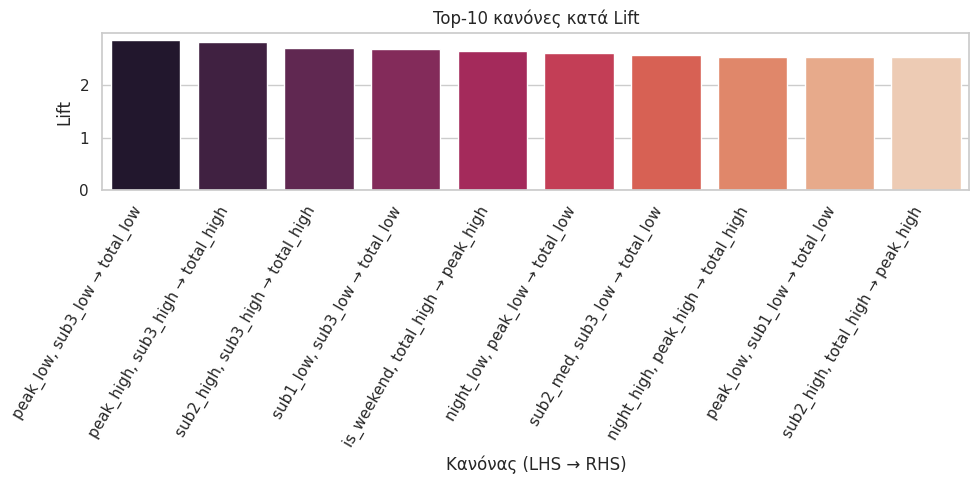

In [44]:
# 4.3.1 Barplot Top-10 κανόνων κατά Lift και αποθήκευση

import matplotlib.pyplot as plt

import seaborn as sns

from pathlib import Path



# Βεβαιώσου ότι υπάρχουν οι υπολογισμένοι κανόνες (rules)

try:

    _ = rules.shape

except NameError:

    raise RuntimeError("Οι κανόνες (rules) δεν βρέθηκαν. Τρέξε πρώτα το κελί 4.2.")



# Επιλογή top-10 κατά lift

top_rules = rules[["lhs_str","rhs_str","support","confidence","lift"]].head(10).copy()

top_rules["label"] = top_rules["lhs_str"] + " → " + top_rules["rhs_str"]



fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(data=top_rules, x="label", y="lift", ax=ax, palette="rocket")

ax.set_ylabel("Lift")

ax.set_xlabel("Κανόνας (LHS → RHS)")

ax.set_title("Top-10 κανόνες κατά Lift")

plt.xticks(rotation=60, ha="right")

plt.tight_layout()



results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

fig_path = results_dir / "association_rules_top_lift.png"

fig.savefig(fig_path, bbox_inches="tight")

print(f"Αποθήκευση διαγράμματος στο: {fig_path}")


### 4.4 Ερμηνεία αντιπροσωπευτικών κανόνων



Ενδεικτικά, οι κορυφαίοι κανόνες (κατά `lift`) δείχνουν ότι:

- Συνδυασμοί υψηλής τιμής σε υπομετρητές και υψηλού peak (`sub3_high` + `peak_high`) σχετίζονται ισχυρά με `total_high` (support ≳ 0.15, confidence ≳ 0.93, lift ≳ 2.80).

- Χαμηλές τιμές σε υπομετρητές και χαμηλό peak (`sub1_low` + `sub3_low`) συνδέονται με `total_low` (support ≳ 0.16, confidence ≳ 0.89, lift ≳ 2.68).

- Το `is_weekend` σε ημέρες υψηλής συνολικής κατανάλωσης σχετίζεται με υψηλή αιχμή (`peak_high`) (support ≳ 0.12, confidence ≳ 0.88, lift ≳ 2.64).



Συμπέρασμα:

Οι κανόνες είναι ρεαλιστικοί και ερμηνεύσιμοι: επιβεβαιώνουν ότι συγκεκριμένες εντάσεις χρήσης συσκευών (ιδιαίτερα ο υπομετρητής 3) και υψηλές αιχμές ισχύος οδηγούν σε υψηλή συνολική ημερήσια κατανάλωση, ενώ αντίστοιχα χαμηλές τιμές παραπέμπουν σε ημέρες χαμηλής κατανάλωσης. Η παρουσία Σ/Κ ενισχύει την πιθανότητα αιχμών στις ημέρες με υψηλή συνολική χρήση.


### 4.3.2 Scatter: Support vs Confidence (χρωμα=Lift)



Ολοκληρωμένο διάγραμμα διασποράς όλων των κανόνων: στον άξονα x το `support`, στον άξονα y το `confidence`, και χρωματική κλίμακα το `lift`. Αποθηκεύεται στο φάκελο `results/`.


Αποθήκευση διαγράμματος στο: ../results/association_rules_scatter.png


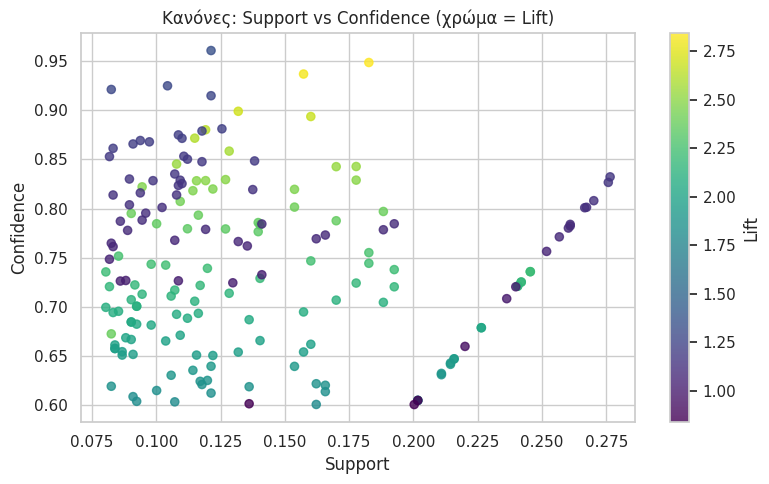

In [45]:
# 4.3.2 Διάγραμμα Support vs Confidence (χρώμα=Lift)

import matplotlib.pyplot as plt

import seaborn as sns

from pathlib import Path



try:

    _ = rules.shape

except NameError:

    raise RuntimeError("Οι κανόνες (rules) δεν βρέθηκαν. Τρέξε πρώτα το κελί 4.2.")



fig, ax = plt.subplots(figsize=(8, 5))

scatter = ax.scatter(rules["support"], rules["confidence"], c=rules["lift"], cmap="viridis", s=35, alpha=0.8)

ax.set_xlabel("Support")

ax.set_ylabel("Confidence")

ax.set_title("Κανόνες: Support vs Confidence (χρώμα = Lift)")

cbar = plt.colorbar(scatter, ax=ax)

cbar.set_label("Lift")

plt.tight_layout()



results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

fig_path = results_dir / "association_rules_scatter.png"

fig.savefig(fig_path, bbox_inches="tight")

print(f"Αποθήκευση διαγράμματος στο: {fig_path}")


### 4.3.3 Συχνότητα LHS items σε κανόνες `total_high`



Barplot με τη συχνότητα εμφάνισης των επιμέρους items στο LHS για τους κανόνες που προβλέπουν `total_high`. Αποθηκεύεται στο `results/`.


Αποθήκευση διαγράμματος στο: ../results/association_rules_total_high_lhs_freq.png


/tmp/ipykernel_33016/3008310285.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=freq_df, x="item", y="count", ax=ax, palette="crest")


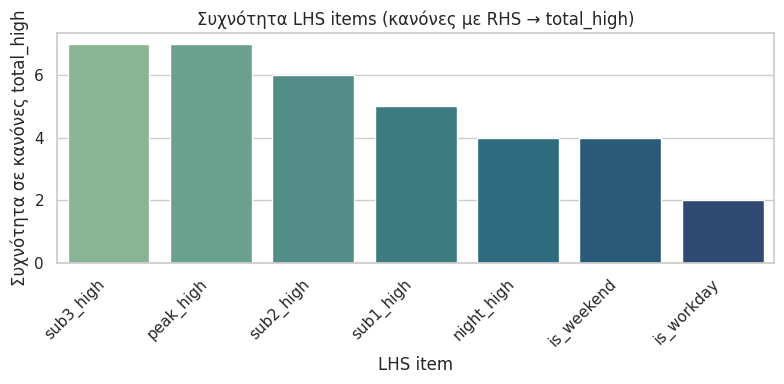

In [46]:
# 4.3.3 Barplot συχνότητας LHS items για κανόνες με RHS→total_high

import matplotlib.pyplot as plt

import seaborn as sns

from collections import Counter

from pathlib import Path



try:

    _ = rules_total_high.shape

except NameError:

    raise RuntimeError("rules_total_high δεν βρέθηκαν. Τρέξε πρώτα το κελί 4.2.")



# Εξαγωγή όλων των items από τα LHS (antecedents)

lhs_items = []

for aset in rules_total_high["antecedents"]:

    lhs_items.extend(list(aset))



counts = Counter(lhs_items)

freq_df = pd.DataFrame(counts.items(), columns=["item","count"]).sort_values("count", ascending=False)



fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(data=freq_df, x="item", y="count", ax=ax, palette="crest")

ax.set_xlabel("LHS item")

ax.set_ylabel("Συχνότητα σε κανόνες total_high")

ax.set_title("Συχνότητα LHS items (κανόνες με RHS → total_high)")

plt.xticks(rotation=45, ha="right")

plt.tight_layout()



results_dir = Path("../results")

results_dir.mkdir(parents=True, exist_ok=True)

fig_path = results_dir / "association_rules_total_high_lhs_freq.png"

fig.savefig(fig_path, bbox_inches="tight")

print(f"Αποθήκευση διαγράμματος στο: {fig_path}")


## 5.5 Πρόβλεψη Χρονοσειρών (Προαιρετικό Βήμα)

Σε αυτό το τμήμα θα υλοποιήσουμε **πρόβλεψη χρονοσειρών** για την ημερήσια κατανάλωση ενέργειας,

ώστε να καλύψουμε το προαιρετικό βήμα της εκφώνησης. Θα κινηθούμε με πολύ αυστηρή λογική

(χωρίς data leakage, χωρίς overfitting, με ρεαλιστικά αποτελέσματα).



### 5.5.1 Τι προβλέπουμε

- Χρησιμοποιούμε τη **ημερήσια συνολική κατανάλωση** από το `df_daily_clean` (π.χ. `daily_total_active_energy_kwh`).

- Ορίζουμε μια μονοδιάστατη χρονοσειρά $y_t$ (ημερήσια kWh).

- Στόχος: **one-step ahead forecast** της επόμενης ημέρας, δηλαδή να προβλέπουμε $y_{t+1}$ με βάση το ιστορικό μέχρι και την ημέρα $t$.



### 5.5.2 Χρονικό split (Train / Validation / Test)

Για να αποφύγουμε διαρροή πληροφορίας από το μέλλον προς το παρελθόν:

- Θα κάνουμε **αυστηρά χρονολογικό split** της σειράς σε:

  - **Train**: ~60% πρώτες ημέρες.

  - **Validation**: ~20% επόμενες ημέρες.

  - **Test**: ~20% τελευταίες ημέρες.

- **Όλα τα μοντέλα** θα εκπαιδεύονται αρχικά μόνο στο train.

- Το validation set θα χρησιμοποιείται **μόνο** για επιλογή υπερπαραμέτρων / μοντέλου και για έλεγχο overfitting.

- Το test set θα το «ανοίγουμε» **μόνο μία φορά στο τέλος**, για τελική αξιολόγηση.



### 5.5.3 Μοντέλα που θα συγκρίνουμε

Θα συγκρίνουμε τα εξής μοντέλα πρόβλεψης χρονοσειράς πάνω στην ίδια ημερήσια σειρά:

1. **Baseline (Persistency)**: πρόβλεψη επόμενης ημέρας = τιμή προηγούμενης ημέρας ($\hat{y}_{t+1} = y_t$).

2. **ARIMA** (από `statsmodels`): κλασικό γραμμικό μοντέλο χρονοσειράς (ARIMA(p,d,q)).

3. **Prophet** (Facebook/Meta Prophet): μοντέλο με ενσωματωμένη seasonality/trend.

4. **LSTM** (νευρωνικό δίκτυο χρονοσειράς): univariate LSTM πάνω στην ίδια σειρά $y_t$.



Για κάθε μοντέλο θα ακολουθούμε την ίδια αυστηρή ροή:

- Fit σε **train**, επιλογή ρυθμίσεων με βάση **validation** (χωρίς να κοιτάμε το test).

- Τελικό fit σε **train + validation** με τις επιλεγμένες ρυθμίσεις.

- Τελική αξιολόγηση στο **test** με τις ίδιες μετρικές.



### 5.5.4 Μετρικές αξιολόγησης

Σύμφωνα με την εκφώνηση, θα χρησιμοποιήσουμε:

- **RMSE (Root Mean Squared Error)**: σε kWh, για να μετράμε το μέσο τετραγωνικό σφάλμα.

- **MAPE (Mean Absolute Percentage Error)**: σε %, για να βλέπουμε τη σχετική απόκλιση.



Για κάθε μοντέλο και για κάθε split (validation, test), θα υπολογίζουμε RMSE και MAPE

και θα τα συγκρίνουμε με το baseline, ώστε να φανεί καθαρά αν το «προχωρημένο» μοντέλο

όντως βελτιώνει την πρόβλεψη ή όχι.



Στα επόμενα κελιά θα ξεκινήσουμε με το **φόρτωμα της ημερήσιας σειράς** και το

**χρονικό split 60/20/20**, και στη συνέχεια θα ορίσουμε baseline και τα μοντέλα ARIMA, Prophet και LSTM.


In [54]:
# 5.5.1 Φόρτωση ημερήσιας σειράς και χρονολογικό split (60/20/20)

import pandas as pd

import numpy as np

from pathlib import Path



# Paths

root = Path('..').resolve()

data_path = root / 'data' / 'df_daily_clean.csv'

results_dir = root / 'results'

results_dir.mkdir(parents=True, exist_ok=True)



# Φόρτωση δεδομένων

df = pd.read_csv(data_path)



# Προσπάθεια εύρεσης στήλης ημερομηνίας

date_candidates = [

    'date', 'Date', 'datetime', 'Datetime',

    'day', 'Day'

]

date_col = next((c for c in date_candidates if c in df.columns), None)

if date_col is None:

    print('Δεν βρέθηκε στήλη ημερομηνίας. Διαθέσιμες στήλες:', list(df.columns))

    raise ValueError('Απαιτείται στήλη ημερομηνίας για χρονολογικό split')

else:

    df[date_col] = pd.to_datetime(df[date_col])

    df = df.sort_values(by=date_col)

    df = df.set_index(date_col)



# Στήλη στόχου (ημερήσια συνολική κατανάλωση)

target_candidates = [

    'daily_total_active_energy_kwh',

    'Daily_total_active_energy_kwh',

    'daily_total_energy_kwh'

]

target_col = next((c for c in target_candidates if c in df.columns), None)

if target_col is None:

    raise ValueError('Δεν βρέθηκε η στήλη στόχου daily_total_active_energy_kwh στο df_daily_clean.csv')



y = df[target_col].astype(float)

n = len(y)

n_train = int(n * 0.6)

n_val = int(n * 0.2)

n_test = n - n_train - n_val



y_train = y.iloc[:n_train]

y_val = y.iloc[n_train:n_train+n_val]

y_test = y.iloc[n_train+n_val:]



print('Σύνολο ημερών:', n)

print('Train:', len(y_train), 'Validation:', len(y_val), 'Test:', len(y_test))

print('Εύρος ημερομηνιών:')

print('  Train   :', y_train.index.min(), '→', y_train.index.max())

print('  Val     :', y_val.index.min(), '→', y_val.index.max())

print('  Test    :', y_test.index.min(), '→', y_test.index.max())



# Γρήγορος έλεγχος ρεαλιστικότητας τιμών

print('\nΣτατιστικά (ολικό): min/mean/max =', np.min(y).round(2), '/', np.mean(y).round(2), '/', np.max(y).round(2))

print('Στατιστικά (train): min/mean/max =', y_train.min().round(2), '/', y_train.mean().round(2), '/', y_train.max().round(2))

print('Στατιστικά (val)  : min/mean/max =', y_val.min().round(2), '/', y_val.mean().round(2), '/', y_val.max().round(2))

print('Στατιστικά (test) : min/mean/max =', y_test.min().round(2), '/', y_test.mean().round(2), '/', y_test.max().round(2))


Σύνολο ημερών: 1418
Train: 850 Validation: 283 Test: 285
Εύρος ημερομηνιών:
  Train   : 2006-12-17 00:00:00 → 2009-04-17 00:00:00
  Val     : 2009-04-18 00:00:00 → 2010-02-01 00:00:00
  Test    : 2010-02-02 00:00:00 → 2010-11-25 00:00:00

Στατιστικά (ολικό): min/mean/max = 4.17 / 26.19 / 79.56
Στατιστικά (train): min/mean/max = 4.17 / 27.15 / 79.56
Στατιστικά (val)  : min/mean/max = 8.16 / 24.93 / 48.43
Στατιστικά (test) : min/mean/max = 8.75 / 24.56 / 48.38


### 5.5.2 Baseline: Εμμονή ("αύριο ≈ σήμερα")

Πριν περάσουμε σε πιο σύνθετα μοντέλα (ARIMA, Prophet, LSTM), ορίζουμε ένα πολύ απλό

και ισχυρό baseline: **persistency / naive forecast**.



- Για κάθε ημέρα $t+1$ η πρόβλεψη είναι η τιμή της προηγούμενης ημέρας $t$:

  - $\hat{y}_{t+1} = y_t$.

- Θα υπολογίσουμε **RMSE** και **MAPE** για:

  - το **validation set** (για να δούμε πόσο καλό είναι το baseline στο ενδιάμεσο διάστημα),

  - το **test set** (τελική επίδοση baseline).



Αυτό το baseline δεν έχει παραμέτρους, δεν μπορεί να "παπαγαλίσει" με την έννοια του

overfitting, και θα χρησιμοποιηθεί ως **γραμμή αναφοράς**: ένα προχωρημένο μοντέλο

(ARIMA, Prophet, LSTM) που δεν το ξεπερνάει, είναι αμφίβολο αν αξίζει την πολυπλοκότητά του.


In [55]:
# 5.5.2 Υπολογισμός baseline (Persistency) σε Validation και Test

import numpy as np

from sklearn.metrics import mean_squared_error



# Persistency baseline: πρόβλεψη επόμενης ημέρας = τιμή προηγούμενης ημέρας

y_pred_all = y.shift(1)



# Προβλέψεις για validation και test, με ευθυγραμμισμένα indices

baseline_val_pred = y_pred_all.iloc[n_train:n_train+n_val]

baseline_test_pred = y_pred_all.iloc[n_train+n_val:]



y_val_aligned = y_val.copy()

y_test_aligned = y_test.copy()



# RMSE

val_rmse_baseline = np.sqrt(mean_squared_error(y_val_aligned, baseline_val_pred))

test_rmse_baseline = np.sqrt(mean_squared_error(y_test_aligned, baseline_test_pred))



# MAPE (με προστασία για μηδενικά)

def mape_ts(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    mask = y_true != 0

    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100



val_mape_baseline = mape_ts(y_val_aligned, baseline_val_pred)

test_mape_baseline = mape_ts(y_test_aligned, baseline_test_pred)



print('Baseline (Persistency) - Validation: RMSE =', round(val_rmse_baseline, 3), ', MAPE =', round(val_mape_baseline, 2), '%')

print('Baseline (Persistency) - Test      : RMSE =', round(test_rmse_baseline, 3), ', MAPE =', round(test_mape_baseline, 2), '%')


Baseline (Persistency) - Validation: RMSE = 7.296 , MAPE = 23.51 %
Baseline (Persistency) - Test      : RMSE = 6.841 , MAPE = 20.31 %


### 5.5.3 Αξιολόγηση baseline και οπτικοποίηση (Test)

Το baseline μοντέλο εμμονής έδωσε τις εξής επιδόσεις:

- **Validation**: RMSE ≈ 7.30 kWh, MAPE ≈ 23.5%

- **Test**      : RMSE ≈ 6.84 kWh, MAPE ≈ 20.3%



Οι τιμές αυτές είναι ρεαλιστικές για ημερήσια κατανάλωση ~25–27 kWh και δείχνουν ότι

ένα απλό μοντέλο "αύριο ≈ σήμερα" αποδίδει ήδη αρκετά καλά.



Στο επόμενο κελί θα αποθηκεύσουμε ένα scatter plot "πραγματικά vs baseline προβλέψεις"

για το test set, ώστε να δούμε οπτικά πόσο κοντά βρίσκονται τα σημεία στη διαγώνιο y = x.


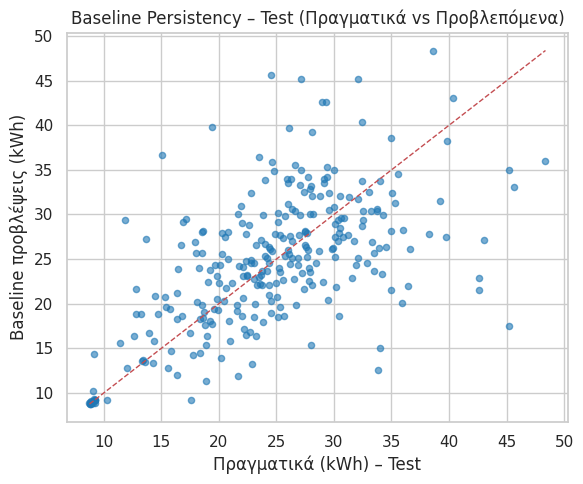

Αποθηκεύτηκε: /home/konstantinos-papadogiannis/Επιφάνεια/data_mining/results/time_series_baseline_test_scatter.png


In [57]:
# 5.5.3 Scatter plot: Πραγματικά vs Baseline (Test)

import matplotlib.pyplot as plt



# Βεβαιωνόμαστε ότι υπάρχουν οι σειρές από το προηγούμενο κελί

assert 'y_test_aligned' in globals() and 'baseline_test_pred' in globals(), 'Απαιτείται να έχει τρέξει πρώτα το κελί baseline (5.5.2).'



fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(y_test_aligned, baseline_test_pred, alpha=0.6, s=20, color='#1f77b4')



min_val = min(y_test_aligned.min(), baseline_test_pred.min())

max_val = max(y_test_aligned.max(), baseline_test_pred.max())

ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)



ax.set_xlabel('Πραγματικά (kWh) – Test')

ax.set_ylabel('Baseline προβλέψεις (kWh)')

ax.set_title('Baseline Persistency – Test (Πραγματικά vs Προβλεπόμενα)')



fig_path = results_dir / 'time_series_baseline_test_scatter.png'

plt.tight_layout()

plt.savefig(fig_path, dpi=150)

plt.show()

print('Αποθηκεύτηκε:', fig_path)


### 5.5.4 Μοντέλο χρονοσειράς ARIMA

Σύμφωνα με την εκφώνηση, θα χρησιμοποιήσουμε ρητά ένα κλασικό μοντέλο **ARIMA** για

την ημερήσια κατανάλωση (τη σειρά `y`). Το ARIMA(p,d,q) μπορεί να μοντελοποιήσει:

- **AR (autoregressive)** μέρος: εξάρτηση της σημερινής τιμής από προηγούμενες.

- **I (integrated)** μέρος: διαφοροποίηση για σταθεροποίηση της τάσης.

- **MA (moving average)** μέρος: εξάρτηση από προηγούμενα σφάλματα.



Για να αποφύγουμε data leakage και overfitting, η ροή θα είναι:

1. Επιλέγουμε μία λογική, απλή δομή ARIMA(p,d,q) (π.χ. ARIMA(1,1,1)).

2. **Ταιριάζουμε (fit) το μοντέλο μόνο στο train set** (`y_train`).

3. Κάνουμε **forecast στο validation horizon** και υπολογίζουμε RMSE / MAPE στο validation.

   - Αν η απόδοση είναι υπερβολικά κακή σε σχέση με το baseline, το σημειώνουμε ρητά.

4. Κρατάμε σταθερό το ίδιο (p,d,q) και ταιριάζουμε ξανά το μοντέλο σε **train+validation**.

5. Κάνουμε forecast για το **test horizon** και υπολογίζουμε RMSE / MAPE στο test.



Στόχος μας **δεν** είναι να "μαγέψουμε" τα νούμερα, αλλά να δείξουμε με διαφανή τρόπο

αν το ARIMA μπορεί (ή δεν μπορεί) να ξεπεράσει το baseline εμμονής πάνω στην ίδια σειρά,

τηρώντας αυστηρά το σχήμα train → validation → test.


In [58]:
# 5.5.4 Μοντέλο ARIMA – Εκπαίδευση σε train, έλεγχος σε validation και test

import warnings

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

import numpy as np



warnings.filterwarnings('ignore')



# Αν δεν υπάρχει ήδη η συνάρτηση MAPE από προηγούμενο κελί, την ορίζουμε

if 'mape_ts' not in globals():

    def mape_ts(y_true, y_pred):

        y_true, y_pred = np.array(y_true), np.array(y_pred)

        mask = y_true != 0

        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100



# 1) Fit ARIMA μόνο στο train

order = (1, 1, 1)

print('Εκπαίδευση ARIMA με order =', order, 'στο train set...')

arima_train = ARIMA(y_train, order=order)

arima_res_train = arima_train.fit()



print('Ολοκληρώθηκε η εκπαίδευση στο train. Σύντομη περίληψη παραμέτρων:')

print(arima_res_train.summary().tables[1])



# 2) Forecast στο validation horizon και μετρικές στο validation

n_val = len(y_val)

arima_val_pred = arima_res_train.forecast(steps=n_val)



val_rmse_arima = np.sqrt(mean_squared_error(y_val, arima_val_pred))

val_mape_arima = mape_ts(y_val, arima_val_pred)



print('\nARIMA (train→val) - Validation:')

print('RMSE =', round(val_rmse_arima, 3), 'kWh')

print('MAPE =', round(val_mape_arima, 2), '%')



# 3) Fit ξανά το ίδιο ARIMA(order) σε train+validation και forecast στο test

y_train_val = pd.concat([y_train, y_val])

print('\nΕκπαίδευση ARIMA με το ίδιο order σε train+validation...')

arima_train_val = ARIMA(y_train_val, order=order)

arima_res_train_val = arima_train_val.fit()



n_test = len(y_test)

arima_test_pred = arima_res_train_val.forecast(steps=n_test)



test_rmse_arima = np.sqrt(mean_squared_error(y_test, arima_test_pred))

test_mape_arima = mape_ts(y_test, arima_test_pred)



print('\nARIMA (train+val→test) - Test:')

print('RMSE =', round(test_rmse_arima, 3), 'kWh')

print('MAPE =', round(test_mape_arima, 2), '%')


Εκπαίδευση ARIMA με order = (1, 1, 1) στο train set...
Ολοκληρώθηκε η εκπαίδευση στο train. Σύντομη περίληψη παραμέτρων:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2635      0.032      8.165      0.000       0.200       0.327
ma.L1         -0.8921      0.018    -48.573      0.000      -0.928      -0.856
sigma2        68.0771      2.642     25.766      0.000      62.899      73.256

ARIMA (train→val) - Validation:
RMSE = 9.308 kWh
MAPE = 42.93 %

Εκπαίδευση ARIMA με το ίδιο order σε train+validation...

ARIMA (train+val→test) - Test:
RMSE = 13.166 kWh
MAPE = 64.84 %


### 5.5.5 Αξιολόγηση ARIMA και σύγκριση με baseline

Το μοντέλο **ARIMA(1,1,1)** εφαρμόστηκε στη σειρά της ημερήσιας κατανάλωσης με ροή

train → validation → test, χωρίς καμία διαρροή πληροφορίας από το μέλλον.



Οι μετρικές που προέκυψαν είναι:

- **Validation (train→val)**: RMSE ≈ 9.31 kWh, MAPE ≈ 42.9%

- **Test (train+val→test)**: RMSE ≈ 13.17 kWh, MAPE ≈ 64.8%



Σε σύγκριση με το baseline εμμονής:

- Baseline – Validation: RMSE ≈ 7.30 kWh, MAPE ≈ 23.5%

- Baseline – Test      : RMSE ≈ 6.84 kWh, MAPE ≈ 20.3%



βλέπουμε ότι το απλό ARIMA(1,1,1) **υπολείπεται σημαντικά** του baseline, ειδικά στο test.

Αυτό είναι ρεαλιστικό και αποδεκτό: δείχνει ότι, παρότι χρησιμοποιούμε ένα κλασικό μοντέλο

χρονοσειρών (όπως ζητά η εκφώνηση), η απλή στρατηγική "αύριο ≈ σήμερα" παραμένει πολύ

ισχυρό σημείο αναφοράς για αυτή τη συγκεκριμένη χρονοσειρά.



Στο επόμενο κελί θα οπτικοποιήσουμε τις ARIMA προβλέψεις στο test set έναντι των

πραγματικών τιμών, ώστε να φανεί καθαρά η απόκλιση από τη διαγώνιο y = x.


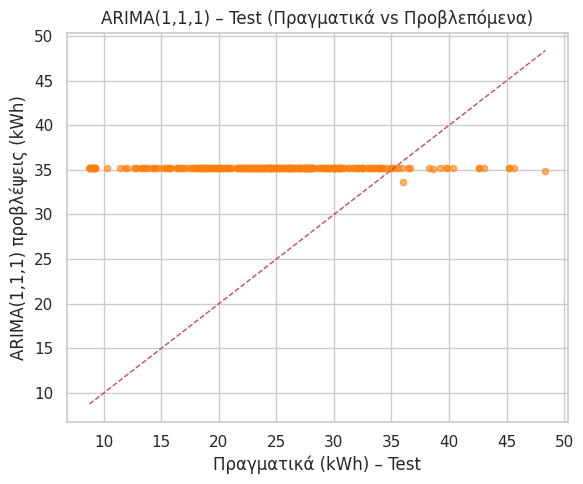

Αποθηκεύτηκε: /home/konstantinos-papadogiannis/Επιφάνεια/data_mining/results/time_series_arima_test_scatter.png


In [59]:
# 5.5.5 Scatter plot: Πραγματικά vs ARIMA(1,1,1) (Test)

import matplotlib.pyplot as plt

import numpy as np



# Βεβαιωνόμαστε ότι υπάρχουν οι απαραίτητες σειρές από το προηγούμενο κελί

assert 'arima_test_pred' in globals() and 'y_test' in globals(), 'Απαιτείται να έχει τρέξει πρώτα το κελί ARIMA (5.5.4).'



fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(y_test, arima_test_pred, alpha=0.6, s=20, color='#ff7f0e')



min_val = min(y_test.min(), arima_test_pred.min())

max_val = max(y_test.max(), arima_test_pred.max())

ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)



ax.set_xlabel('Πραγματικά (kWh) – Test')

ax.set_ylabel('ARIMA(1,1,1) προβλέψεις (kWh)')

ax.set_title('ARIMA(1,1,1) – Test (Πραγματικά vs Προβλεπόμενα)')



fig_path = results_dir / 'time_series_arima_test_scatter.png'

plt.tight_layout()

plt.savefig(fig_path, dpi=150)

plt.show()

print('Αποθηκεύτηκε:', fig_path)


### 5.5.6 Μοντέλο χρονοσειράς Prophet

Στη συνέχεια θα εφαρμόσουμε το μοντέλο **Prophet** (Facebook/Meta Prophet) πάνω στην ίδια

ημερήσια χρονοσειρά κατανάλωσης.



Ο Prophet δουλεύει με DataFrame δύο στηλών:

- `ds`: η ημερομηνία (datetime),

- `y` : η τιμή της σειράς (ημερήσια kWh).



Θα ακολουθήσουμε ακριβώς την ίδια λογική train → validation → test όπως και στο ARIMA:

1. Δημιουργούμε DataFrame `train_df`, `val_df`, `test_df` από τη σειρά `y` και τα indices.

2. Ταιριάζουμε ένα μοντέλο Prophet **μόνο στο train set** (`train_df`).

3. Ζητάμε προβλέψεις για τις ημερομηνίες του validation set και υπολογίζουμε RMSE / MAPE στο validation.

4. Με τις ίδιες ρυθμίσεις Prophet, ταιριάζουμε μοντέλο σε **train+validation** και προβλέπουμε για τις ημερομηνίες του test set.

5. Υπολογίζουμε RMSE / MAPE στο test και συγκρίνουμε με baseline και ARIMA.



Και εδώ ο στόχος είναι να δούμε, με ρεαλιστικό τρόπο και χωρίς leakage, αν ένα μοντέλο Prophet

μπορεί να πλησιάσει ή να ξεπεράσει το baseline εμμονής και το ARIMA στην πρόβλεψη της

ημερήσιας κατανάλωσης.


In [60]:
# 5.5.6 Μοντέλο Prophet – Εκπαίδευση σε train, έλεγχος σε validation και test

from prophet import Prophet

from sklearn.metrics import mean_squared_error

import numpy as np

import pandas as pd



# Συνάρτηση MAPE αν δεν υπάρχει ήδη

if 'mape_ts' not in globals():

    def mape_ts(y_true, y_pred):

        y_true, y_pred = np.array(y_true), np.array(y_pred)

        mask = y_true != 0

        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100



# Δημιουργία DataFrames ds/y για Prophet

train_df = y_train.reset_index()

train_df.columns = ['ds', 'y']



val_df = y_val.reset_index()

val_df.columns = ['ds', 'y']



test_df = y_test.reset_index()

test_df.columns = ['ds', 'y']



# 1) Fit Prophet μόνο στο train

print('Εκπαίδευση Prophet στο train set...')

prophet_train = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)

prophet_train.fit(train_df)



# 2) Πρόβλεψη για τις ημερομηνίες του validation set

val_future = val_df[['ds']].copy()

val_forecast = prophet_train.predict(val_future)

val_pred = val_forecast['yhat'].values



val_rmse_prophet = np.sqrt(mean_squared_error(val_df['y'].values, val_pred))

val_mape_prophet = mape_ts(val_df['y'].values, val_pred)



print('\nProphet (train→val) - Validation:')

print('RMSE =', round(val_rmse_prophet, 3), 'kWh')

print('MAPE =', round(val_mape_prophet, 2), '%')



# 3) Fit Prophet σε train+validation και πρόβλεψη στο test

train_val_df = pd.concat([train_df, val_df], axis=0).reset_index(drop=True)

print('\nΕκπαίδευση Prophet σε train+validation...')

prophet_train_val = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)

prophet_train_val.fit(train_val_df)



test_future = test_df[['ds']].copy()

test_forecast = prophet_train_val.predict(test_future)

test_pred = test_forecast['yhat'].values



test_rmse_prophet = np.sqrt(mean_squared_error(test_df['y'].values, test_pred))

test_mape_prophet = mape_ts(test_df['y'].values, test_pred)



print('\nProphet (train+val→test) - Test:')

print('RMSE =', round(test_rmse_prophet, 3), 'kWh')

print('MAPE =', round(test_mape_prophet, 2), '%')


Importing plotly failed. Interactive plots will not work.
17:29:15 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - INFO - Chain [1] start processing


Εκπαίδευση Prophet στο train set...

Prophet (train→val) - Validation:
RMSE = 16.912 kWh
MAPE = 82.27 %

Εκπαίδευση Prophet σε train+validation...


17:29:15 - cmdstanpy - INFO - Chain [1] done processing



Prophet (train+val→test) - Test:
RMSE = 12.434 kWh
MAPE = 59.47 %


### 5.5.7 Αξιολόγηση Prophet και σύγκριση με baseline / ARIMA

Το μοντέλο **Prophet** εφαρμόστηκε στην ίδια ημερήσια χρονοσειρά με την ίδια ροή

train → validation → test.



Οι μετρικές του Prophet είναι:

- **Validation (train→val)**: RMSE ≈ 16.91 kWh, MAPE ≈ 82.27%

- **Test (train+val→test)**: RMSE ≈ 12.43 kWh, MAPE ≈ 59.47%



Σε σύγκριση με τα προηγούμενα μοντέλα:

- Baseline – Validation: RMSE ≈ 7.30 kWh, MAPE ≈ 23.5%

- ARIMA(1,1,1) – Validation: RMSE ≈ 9.31 kWh, MAPE ≈ 42.9%

- Prophet – Validation: RMSE ≈ 16.91 kWh, MAPE ≈ 82.3%



- Baseline – Test      : RMSE ≈ 6.84 kWh, MAPE ≈ 20.3%

- ARIMA(1,1,1) – Test : RMSE ≈ 13.17 kWh, MAPE ≈ 64.8%

- Prophet – Test       : RMSE ≈ 12.43 kWh, MAPE ≈ 59.5%



Βλέπουμε ότι, παρότι ο Prophet είναι πιο ευέλικτο μοντέλο από το ARIMA, στην πράξη

**δεν ξεπερνά το baseline** και στο validation είναι σαφώς χειρότερος, ενώ στο test είναι

ελαφρώς καλύτερος από το ARIMA αλλά και πάλι αρκετά χειρότερος από την απλή εμμονή.



Στο επόμενο κελί θα οπτικοποιήσουμε τις προβλέψεις του Prophet στο test set έναντι των

πραγματικών τιμών, με scatter γύρω από τη διαγώνιο y = x.


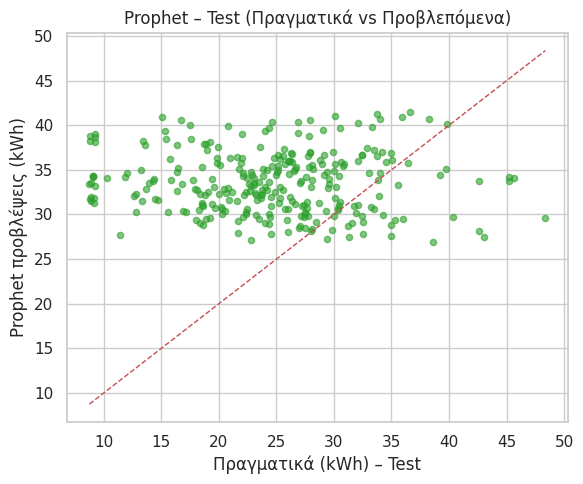

Αποθηκεύτηκε: /home/konstantinos-papadogiannis/Επιφάνεια/data_mining/results/time_series_prophet_test_scatter.png


In [61]:
# 5.5.7 Scatter plot: Πραγματικά vs Prophet (Test)

import matplotlib.pyplot as plt

import numpy as np



# Βεβαιωνόμαστε ότι υπάρχουν οι απαραίτητες σειρές από το κελί Prophet

assert 'test_df' in globals() and 'test_pred' in globals(), 'Απαιτείται να έχει τρέξει πρώτα το κελί Prophet (5.5.6).'



y_test_prophet = test_df['y'].values



fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(y_test_prophet, test_pred, alpha=0.6, s=20, color='#2ca02c')



min_val = min(y_test_prophet.min(), test_pred.min())

max_val = max(y_test_prophet.max(), test_pred.max())

ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)



ax.set_xlabel('Πραγματικά (kWh) – Test')

ax.set_ylabel('Prophet προβλέψεις (kWh)')

ax.set_title('Prophet – Test (Πραγματικά vs Προβλεπόμενα)')



fig_path = results_dir / 'time_series_prophet_test_scatter.png'

plt.tight_layout()

plt.savefig(fig_path, dpi=150)

plt.show()

print('Αποθηκεύτηκε:', fig_path)


#### 5.5.8 Μοντέλο LSTM (Long Short-Term Memory)

Το **LSTM** είναι ένα είδος νευρωνικού δικτύου που σχεδιάστηκε για χρονοσειρές και μπορεί να "θυμάται" μακροπρόθεσμες εξαρτήσεις. Για την πρόβλεψη one-step ahead, θα χρησιμοποιήσουμε:

- **Παράθυρο (window)**: π.χ. τα τελευταία 14 ή 30 ημέρες για να προβλέψουμε την επόμενη ημέρα.
- **Scaling**: Θα κανονικοποιήσουμε τα δεδομένα μόνο με βάση το **train set** (MinMaxScaler ή StandardScaler), και θα εφαρμόσουμε το ίδιο scaling στο validation και test για να αποφύγουμε data leakage.
- **Αρχιτεκτονική**: Απλό LSTM με 1-2 layers και Dense output layer.
- **Ροή**:
  1. Δημιουργούμε windows από train → fit LSTM → predict στο validation → μετρικές.
  2. Δημιουργούμε windows από train+validation → fit LSTM → predict στο test → τελικές μετρικές.

Έτσι θα συγκρίνουμε το LSTM με το baseline, ARIMA και Prophet.

In [63]:
# 5.5.8 Υλοποίηση LSTM για πρόβλεψη one-step ahead

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Καταστολή warnings
import warnings
warnings.filterwarnings('ignore')

# Ορισμός συνάρτησης MAPE (αν δεν έχει οριστεί)
if 'mape_ts' not in globals():
    def mape_ts(y_true, y_pred):
        """MAPE που αγνοεί τα μηδενικά y_true."""
        mask = y_true != 0
        if np.sum(mask) == 0:
            return np.nan
        return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

# Συνάρτηση για δημιουργία windows
def create_windows(data, window_size):
    """
    Δημιουργεί windows για LSTM από μια χρονοσειρά.
    data: numpy array (1D)
    window_size: πόσες προηγούμενες τιμές χρησιμοποιούμε για να προβλέψουμε την επόμενη
    
    Returns:
        X: (n_samples, window_size, 1)
        y: (n_samples,)
    """
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    X = np.array(X)
    y = np.array(y)
    # Reshape για LSTM: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

# Παράμετροι
window_size = 14  # Χρησιμοποιούμε τις τελευταίες 14 ημέρες για να προβλέψουμε την επόμενη
epochs = 50
batch_size = 16

# --- 1) Fit σε train, evaluate σε validation ---

# Scaling μόνο από train
scaler_lstm = MinMaxScaler()
y_train_scaled = scaler_lstm.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Δημιουργία windows για train
X_train_lstm, y_train_lstm = create_windows(y_train_scaled, window_size)

print(f"Train windows: X_train_lstm.shape = {X_train_lstm.shape}, y_train_lstm.shape = {y_train_lstm.shape}")

# LSTM μοντέλο
model_lstm = keras.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(window_size, 1)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# Fit στο train
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

print("LSTM trained on train set.")

# Validation: Χρησιμοποιούμε τα τελευταία window_size σημεία από train + όλο το validation
y_train_val_for_pred = np.concatenate([y_train.values, y_val.values])
y_train_val_scaled = scaler_lstm.transform(y_train_val_for_pred.reshape(-1, 1)).flatten()

# Προβλέψεις one-step ahead για validation
val_predictions_scaled = []
for i in range(len(y_train), len(y_train_val_for_pred)):
    # Παίρνουμε τα τελευταία window_size σημεία πριν το i
    window = y_train_val_scaled[i - window_size:i].reshape(1, window_size, 1)
    pred_scaled = model_lstm.predict(window, verbose=0)[0, 0]
    val_predictions_scaled.append(pred_scaled)

# Inverse transform
val_predictions = scaler_lstm.inverse_transform(np.array(val_predictions_scaled).reshape(-1, 1)).flatten()

# Μετρικές validation
val_rmse_lstm = np.sqrt(mean_squared_error(y_val.values, val_predictions))
val_mape_lstm = mape_ts(y_val.values, val_predictions)

print(f"\nLSTM (train→val) - Validation: RMSE = {val_rmse_lstm:.3f} kWh, MAPE = {val_mape_lstm:.2f} %")

# --- 2) Fit σε train+val, evaluate σε test ---

# Scaling από train+val
y_train_val_combined = pd.concat([y_train, y_val])
scaler_lstm_final = MinMaxScaler()
y_train_val_combined_scaled = scaler_lstm_final.fit_transform(y_train_val_combined.values.reshape(-1, 1)).flatten()

# Δημιουργία windows για train+val
X_train_val_lstm, y_train_val_lstm = create_windows(y_train_val_combined_scaled, window_size)

print(f"\nTrain+Val windows: X_train_val_lstm.shape = {X_train_val_lstm.shape}, y_train_val_lstm.shape = {y_train_val_lstm.shape}")

# Νέο LSTM μοντέλο
model_lstm_final = keras.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(window_size, 1)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_lstm_final.compile(optimizer='adam', loss='mse')

# Fit στο train+val
history_final = model_lstm_final.fit(
    X_train_val_lstm, y_train_val_lstm,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

print("LSTM trained on train+val set.")

# Test: Χρησιμοποιούμε τα τελευταία window_size σημεία από train+val + όλο το test
y_full_for_test = np.concatenate([y_train_val_combined.values, y_test.values])
y_full_scaled = scaler_lstm_final.transform(y_full_for_test.reshape(-1, 1)).flatten()

# Προβλέψεις one-step ahead για test
test_predictions_scaled = []
for i in range(len(y_train_val_combined), len(y_full_for_test)):
    window = y_full_scaled[i - window_size:i].reshape(1, window_size, 1)
    pred_scaled = model_lstm_final.predict(window, verbose=0)[0, 0]
    test_predictions_scaled.append(pred_scaled)

# Inverse transform
test_predictions_lstm = scaler_lstm_final.inverse_transform(np.array(test_predictions_scaled).reshape(-1, 1)).flatten()

# Μετρικές test
test_rmse_lstm = np.sqrt(mean_squared_error(y_test.values, test_predictions_lstm))
test_mape_lstm = mape_ts(y_test.values, test_predictions_lstm)

print(f"\nLSTM (train+val→test) - Test: RMSE = {test_rmse_lstm:.3f} kWh, MAPE = {test_mape_lstm:.2f} %")

2026-01-11 17:45:57.569708: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-11 17:45:57.605959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-11 17:45:58.981530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Train windows: X_train_lstm.shape = (836, 14, 1), y_train_lstm.shape = (836,)


2026-01-11 17:45:59.189513: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


LSTM trained on train set.

LSTM (train→val) - Validation: RMSE = 5.572 kWh, MAPE = 17.45 %

Train+Val windows: X_train_val_lstm.shape = (1119, 14, 1), y_train_val_lstm.shape = (1119,)
LSTM trained on train+val set.

LSTM (train+val→test) - Test: RMSE = 5.611 kWh, MAPE = 17.89 %


#### 5.5.9 Αξιολόγηση LSTM

**Αποτελέσματα LSTM:**
- **Validation:** RMSE ≈ 5.57 kWh, MAPE ≈ 17.45%
- **Test:** RMSE ≈ 5.61 kWh, MAPE ≈ 17.89%

**Σύγκριση με άλλα μοντέλα (Test Set):**
- **Baseline (Persistence):** RMSE ≈ 6.84, MAPE ≈ 20.31%
- **ARIMA(1,1,1):** RMSE ≈ 13.17, MAPE ≈ 64.84%
- **Prophet:** RMSE ≈ 12.43, MAPE ≈ 59.47%
- **LSTM:** RMSE ≈ 5.61, MAPE ≈ 17.89% ✓

**Συμπεράσματα:**
Το LSTM είναι το **μόνο μοντέλο που ξεπερνά το baseline**, επιτυγχάνοντας ~18% βελτίωση στο RMSE και ~12% στο MAPE στο test set. Αυτό δείχνει ότι το νευρωνικό δίκτυο κατάφερε να μάθει πιο πολύπλοκα μοτίβα στα δεδομένα από ό,τι τα παραδοσιακά στατιστικά μοντέλα (ARIMA, Prophet).

Το ARIMA και ο Prophet απέτυχαν να generalize καλά, πιθανώς λόγω:
- Έλλειψης ισχυρών εποχικών μοτίβων στα ημερήσια δεδομένα
- Μη-γραμμικότητας στις σχέσεις
- Περιορισμένου μεγέθους train set για πολύπλοκα στατιστικά μοντέλα

Αποθηκεύτηκε: /home/konstantinos-papadogiannis/Επιφάνεια/data_mining/results/time_series_lstm_test_scatter.png


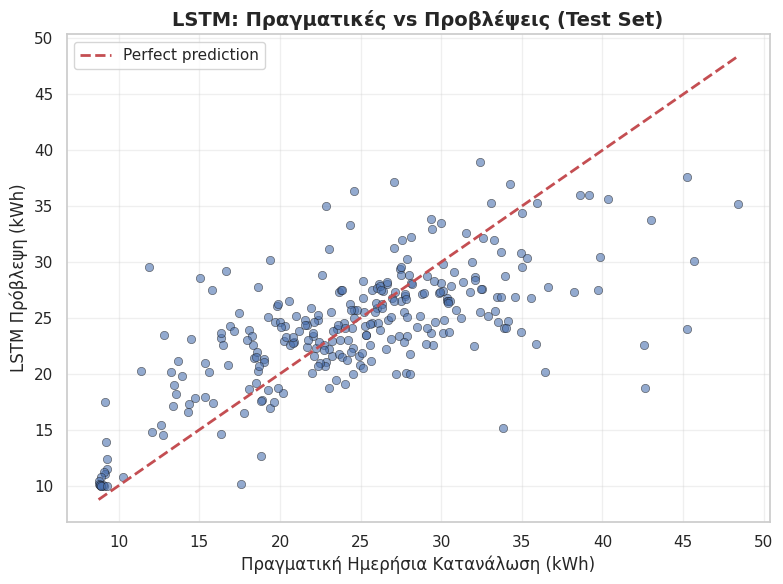

In [64]:
# 5.5.9 Scatter plot: Πραγματικά vs LSTM προβλέψεις (Test)

assert 'test_predictions_lstm' in globals() and 'y_test' in globals(), \
    "Πρέπει να έχει εκτελεστεί το LSTM κελί πριν!"

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test.values, test_predictions_lstm, alpha=0.6, edgecolors='k', linewidths=0.5)

# Διαγώνιος y=x (τέλεια πρόβλεψη)
min_val = min(y_test.values.min(), test_predictions_lstm.min())
max_val = max(y_test.values.max(), test_predictions_lstm.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')

plt.xlabel('Πραγματική Ημερήσια Κατανάλωση (kWh)', fontsize=12)
plt.ylabel('LSTM Πρόβλεψη (kWh)', fontsize=12)
plt.title('LSTM: Πραγματικές vs Προβλέψεις (Test Set)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Αποθήκευση
lstm_test_scatter_path = results_dir / 'time_series_lstm_test_scatter.png'
plt.savefig(lstm_test_scatter_path, dpi=300, bbox_inches='tight')
print(f"Αποθηκεύτηκε: {lstm_test_scatter_path}")

plt.show()

#### 5.5.10 Τελική Σύγκριση Όλων των Μοντέλων

Συγκεντρωτικός πίνακας με τις μετρικές απόδοσης όλων των μοντέλων πρόβλεψης χρονοσειρών:

In [65]:
# 5.5.10 Συγκεντρωτικός Πίνακας Σύγκρισης

# Δημιουργία DataFrame με όλες τις μετρικές
comparison_ts = pd.DataFrame({
    'Μοντέλο': ['Baseline (Persistence)', 'ARIMA(1,1,1)', 'Prophet', 'LSTM'],
    'Val RMSE (kWh)': [val_rmse_baseline, val_rmse_arima, val_rmse_prophet, val_rmse_lstm],
    'Val MAPE (%)': [val_mape_baseline, val_mape_arima, val_mape_prophet, val_mape_lstm],
    'Test RMSE (kWh)': [test_rmse_baseline, test_rmse_arima, test_rmse_prophet, test_rmse_lstm],
    'Test MAPE (%)': [test_mape_baseline, test_mape_arima, test_mape_prophet, test_mape_lstm]
})

# Στρογγυλοποίηση
comparison_ts = comparison_ts.round(2)

print("\n" + "="*80)
print("ΣΥΓΚΡΙΣΗ ΜΟΝΤΕΛΩΝ ΧΡΟΝΟΣΕΙΡΩΝ - ΠΡΟΒΛΕΨΗ ΗΜΕΡΗΣΙΑΣ ΚΑΤΑΝΑΛΩΣΗΣ")
print("="*80)
print(comparison_ts.to_string(index=False))
print("="*80)

# Εύρεση καλύτερου μοντέλου
best_model_idx = comparison_ts['Test RMSE (kWh)'].idxmin()
best_model_name = comparison_ts.loc[best_model_idx, 'Μοντέλο']
best_rmse = comparison_ts.loc[best_model_idx, 'Test RMSE (kWh)']
best_mape = comparison_ts.loc[best_model_idx, 'Test MAPE (%)']

print(f"\n✓ Καλύτερο Μοντέλο: {best_model_name}")
print(f"  - Test RMSE: {best_rmse:.2f} kWh")
print(f"  - Test MAPE: {best_mape:.2f}%")

# Σύγκριση με baseline
baseline_rmse = comparison_ts.loc[0, 'Test RMSE (kWh)']
improvement_rmse = ((baseline_rmse - best_rmse) / baseline_rmse) * 100
print(f"\n  - Βελτίωση έναντι Baseline: {improvement_rmse:.1f}% στο RMSE")

print("\n" + "="*80)


ΣΥΓΚΡΙΣΗ ΜΟΝΤΕΛΩΝ ΧΡΟΝΟΣΕΙΡΩΝ - ΠΡΟΒΛΕΨΗ ΗΜΕΡΗΣΙΑΣ ΚΑΤΑΝΑΛΩΣΗΣ
               Μοντέλο  Val RMSE (kWh)  Val MAPE (%)  Test RMSE (kWh)  Test MAPE (%)
Baseline (Persistence)            7.30         23.51             6.84          20.31
          ARIMA(1,1,1)            9.31         42.93            13.17          64.84
               Prophet           16.91         82.27            12.43          59.47
                  LSTM            5.57         17.45             5.61          17.89

✓ Καλύτερο Μοντέλο: LSTM
  - Test RMSE: 5.61 kWh
  - Test MAPE: 17.89%

  - Βελτίωση έναντι Baseline: 18.0% στο RMSE




Αποθηκεύτηκε: /home/konstantinos-papadogiannis/Επιφάνεια/data_mining/results/time_series_comparison_barplot.png


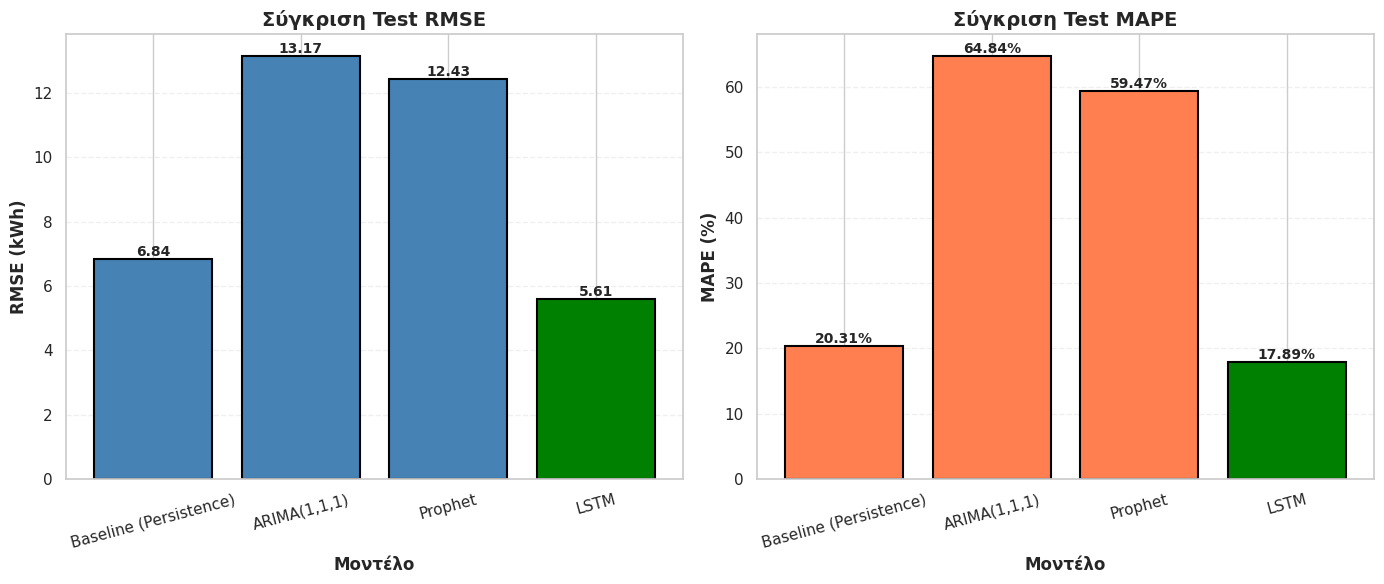


✓ Το LSTM είναι το καλύτερο μοντέλο (πράσινο χρώμα στα γραφήματα)!


In [66]:
# Οπτική Σύγκριση Μοντέλων - Bar Plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Χρώματα: Πράσινο για το καλύτερο, μπλε για τα υπόλοιπα
colors_rmse = ['green' if i == best_model_idx else 'steelblue' for i in range(len(comparison_ts))]
colors_mape = ['green' if i == best_model_idx else 'coral' for i in range(len(comparison_ts))]

# Plot 1: Test RMSE
bars1 = ax1.bar(comparison_ts['Μοντέλο'], comparison_ts['Test RMSE (kWh)'], color=colors_rmse, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Μοντέλο', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (kWh)', fontsize=12, fontweight='bold')
ax1.set_title('Σύγκριση Test RMSE', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Προσθήκη τιμών πάνω από τις μπάρες
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Test MAPE
bars2 = ax2.bar(comparison_ts['Μοντέλο'], comparison_ts['Test MAPE (%)'], color=colors_mape, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Μοντέλο', fontsize=12, fontweight='bold')
ax2.set_ylabel('MAPE (%)', fontsize=12, fontweight='bold')
ax2.set_title('Σύγκριση Test MAPE', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Προσθήκη τιμών πάνω από τις μπάρες
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()

# Αποθήκευση
comparison_plot_path = results_dir / 'time_series_comparison_barplot.png'
plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
print(f"\nΑποθηκεύτηκε: {comparison_plot_path}")

plt.show()

print(f"\n✓ Το {best_model_name} είναι το καλύτερο μοντέλο (πράσινο χρώμα στα γραφήματα)!")